(mmm_allocation_assessment)=
# Budget Allocation Risk Assessment with PyMC-Marketing

The focus of this notebook is on assessing the risk associated with different budget allocations across various marketing channels. By quantifying the potential variability in outcomes, and teaching how to generate a budget allocation that is optimal under a risk tolerance criterion, this notebook provides valuable insights for making informed budget allocation decisions.

## Prerequisite Knowledge
The notebook assumes the reader has knowledge of the essential functionalities of PyMC-Marketing. If one is unfamiliar, the ["MMM Example Notebook"](https://www.pymc-marketing.io/en/stable/notebooks/mmm/mmm_example.html) serves as an excellent starting point, offering a comprehensive introduction to media mix models in this context.

## What to Anticipate
Upon completing this notebook, readers should get a comprehensive understanding of how to assess the risk associated with different budget allocations, and how to generate a budget allocation that is optimal under a risk tolerance criterion.

## Basic Setup
Like previous notebooks in PyMC-Marketing, this relies on a specific library set. Here are the requisite imports necessary for executing the provided code snippets subsequently.


In [1]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np

from pymc_marketing.mmm import MMM

warnings.filterwarnings("ignore")

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

The expectation is that a model has already been trained using the functionalities provided in prior versions of the PyMC-Marketing library. Thus, the data generation and training processes will be replicated in a different notebook. Those unfamiliar with these procedures are advised to refer to the ["MMM Example Notebook."](https://www.pymc-marketing.io/en/stable/notebooks/mmm/mmm_example.html)

## Loading a Pre-Trained Model
To utilize a saved model, load it into a new instance of the MMM class using the load method below.

In [2]:
mmm = MMM.load("model.nc")

## Defining the Budget Allocation Problem
As in previous notebooks, we need define the budget allocation problem. Basically, we must define how long our budget allocation will be, and how much we can spend per time unit. Our model is trained on weekly data, so we will follow the same time granularity.

On this example, we are trying to allocate a budget across two channels over 8 weeks, with a weekly budget of 5M. Meaning, the total budget to allocate is 40M.

In [3]:
num_periods = (
    8  # Number of time periods to allocate the budget (weeks for this example)
)
time_unit_budget = 5  # Imagine is 5K or 5M (per week in this case)

# Define your channels
channels = ["x1", "x2"]

print(f"Total budget to allocate: {num_periods * time_unit_budget}M")

Total budget to allocate: 40M


The usual approach is to allocate the budget to maximize the response. We can use the `allocate_budget_to_maximize_response` method to do so, here we will compute the response given several budget combinations, and we'll prefer the one that maximizes the response. It's important to note that this example doesn't use any bounds, or constraints, so the optimizer will seek to use the entire budget.

Sampling: [y]


Output()

Budget allocation: {'x1': 2.8392426424096517, 'x2': 2.1607573575903483}
Total Allocated Budget: 5.0M


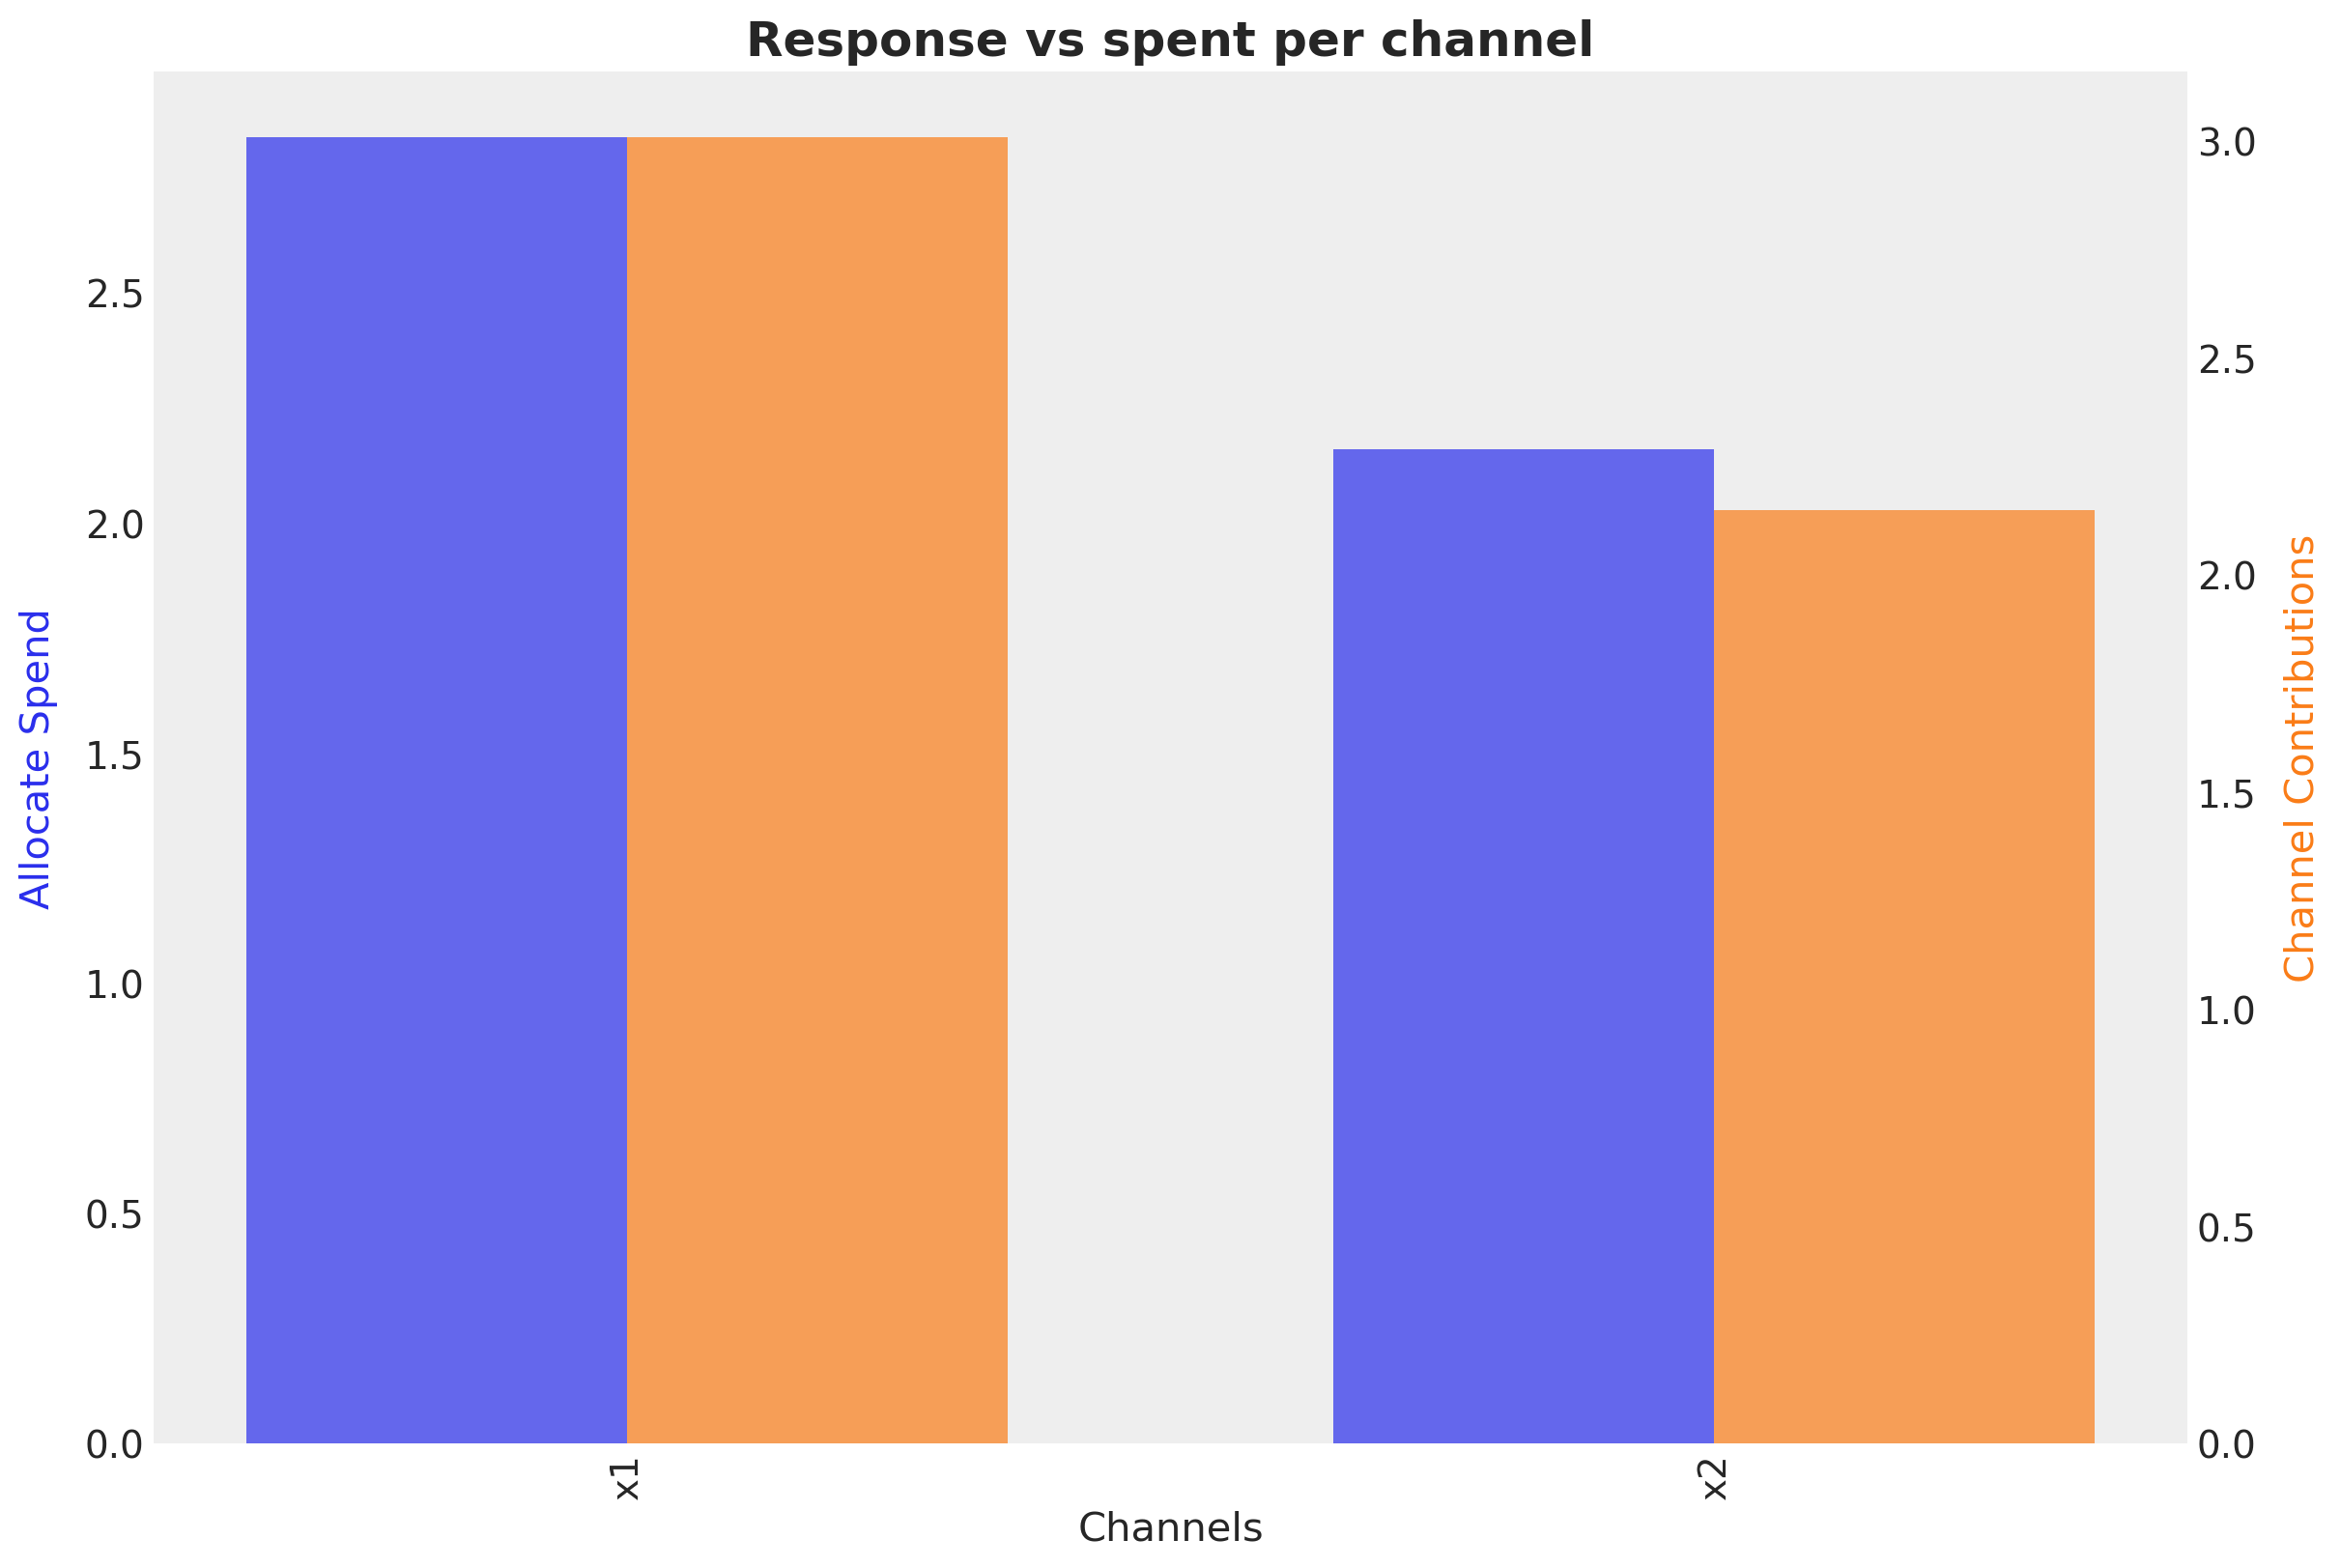

In [4]:
response = mmm.allocate_budget_to_maximize_response(
    budget=time_unit_budget,
    num_periods=num_periods,
    time_granularity="weekly",
)

print(f"Budget allocation: {mmm.optimal_allocation_dict}")
print(f"Total Allocated Budget: {np.sum(list(mmm.optimal_allocation_dict.values()))}M")

fig, ax = mmm.plot_budget_allocation(samples=response, figsize=(12, 8))
ax.set_title("Response vs spent per channel", fontsize=18, fontweight="bold");

We can see that the optimizer is allocating the budget almost evenly between the two channels. $X1$ has an allocation of 2.8M, and $X2$ has an allocation of 2.1M.

## Risk Assessment Introduction
The `budget_optimizer` module contains several risk assessment criteria that can be used to evaluate the risk associated with different budget allocations. Each of these criteria is a statistical method from the class `RiskAssessment`.

You can use the `RiskAssessment` class to compute the risk associated with different budget allocations. If you want to use a custom risk assessment criterion, you can create your own function and pass it to the `allocate_budget_to_maximize_response` method if needed. Later on, we will see how to create your own risk assessment criterion.

In [5]:
from pymc_marketing.mmm.budget_optimizer import RiskAssessment

## Optimizing Budget Allocation with Value at Risk (VaR)
In this section, we aim to optimize our marketing budget allocation while taking risk into account. Specifically, we're using the Value at Risk (VaR) as our objective function to ensure that our budget plan minimizes potential losses within a certain confidence level.

### What's Happening Here?
We call `mmm.allocate_budget_to_maximize_response` to determine the optimal allocation of our marketing budget across different channels over the specified time periods, just as we did in the previous section.

The parameters are the same as in the previous section, with the addition of the `objective_function` and `objective_function_kwargs` parameters. 
In this case:
- `objective_function`: We set this to RiskAssessment.value_at_risk, which means we're using VaR as our optimization criterion.
- `objective_function_kwargs`: We pass {"confidence_level": 0.95} to specify that we're focusing on the 95% confidence level for VaR.

Mean Tightness Score is a risk-adjusted metric that balances the mean return and the tail variability of a distribution. It is calculated as:

$$
Mean\ Tightness\ Score = \mu - \alpha \cdot Tail\ Distance
$$

Where $\mu$ is the mean of the sample returns, $Tail\ Distance$ is the tail distance metric, and $\alpha$ is the risk tolerance parameter.

In [6]:
RiskAssessment.mean_tightness_score?

Signature:
RiskAssessment.mean_tightness_score(
    samples: numpy.ndarray,
    alpha: float = 0.5,
    confidence_level: float = 0.75,
) -> float
Docstring:
Calculate the mean tightness score.

The mean tightness score is a risk metric that balances the mean return and the tail variability.
It is calculated as:

.. math::
    Mean\ Tightness\ Score = \mu - \alpha \cdot Tail\ Distance

where:
    - :math:`\mu` is the mean of the sample returns.
    - :math:`Tail\ Distance` is the tail distance metric.
    - :math:`\alpha` is the risk tolerance parameter.

alpha (Risk Tolerance Parameter): This parameter controls the trade-off.
    - Higher :math:`\alpha` increases sensitivity to variability, making the metric value higher for spread dist
    - Lower :math:`\alpha` decreases sensitivity to variability, making the metric value lower for spread dist
File:      ~/Documents/GitHub/pymc-marketing/pymc_marketing/mmm/budget_optimizer.py
Type:      function

Sampling: [y]


Output()

Budget allocation: {'x1': 3.3201077605687797, 'x2': 1.6798922394312203}
Total Allocated Budget: 5.0M


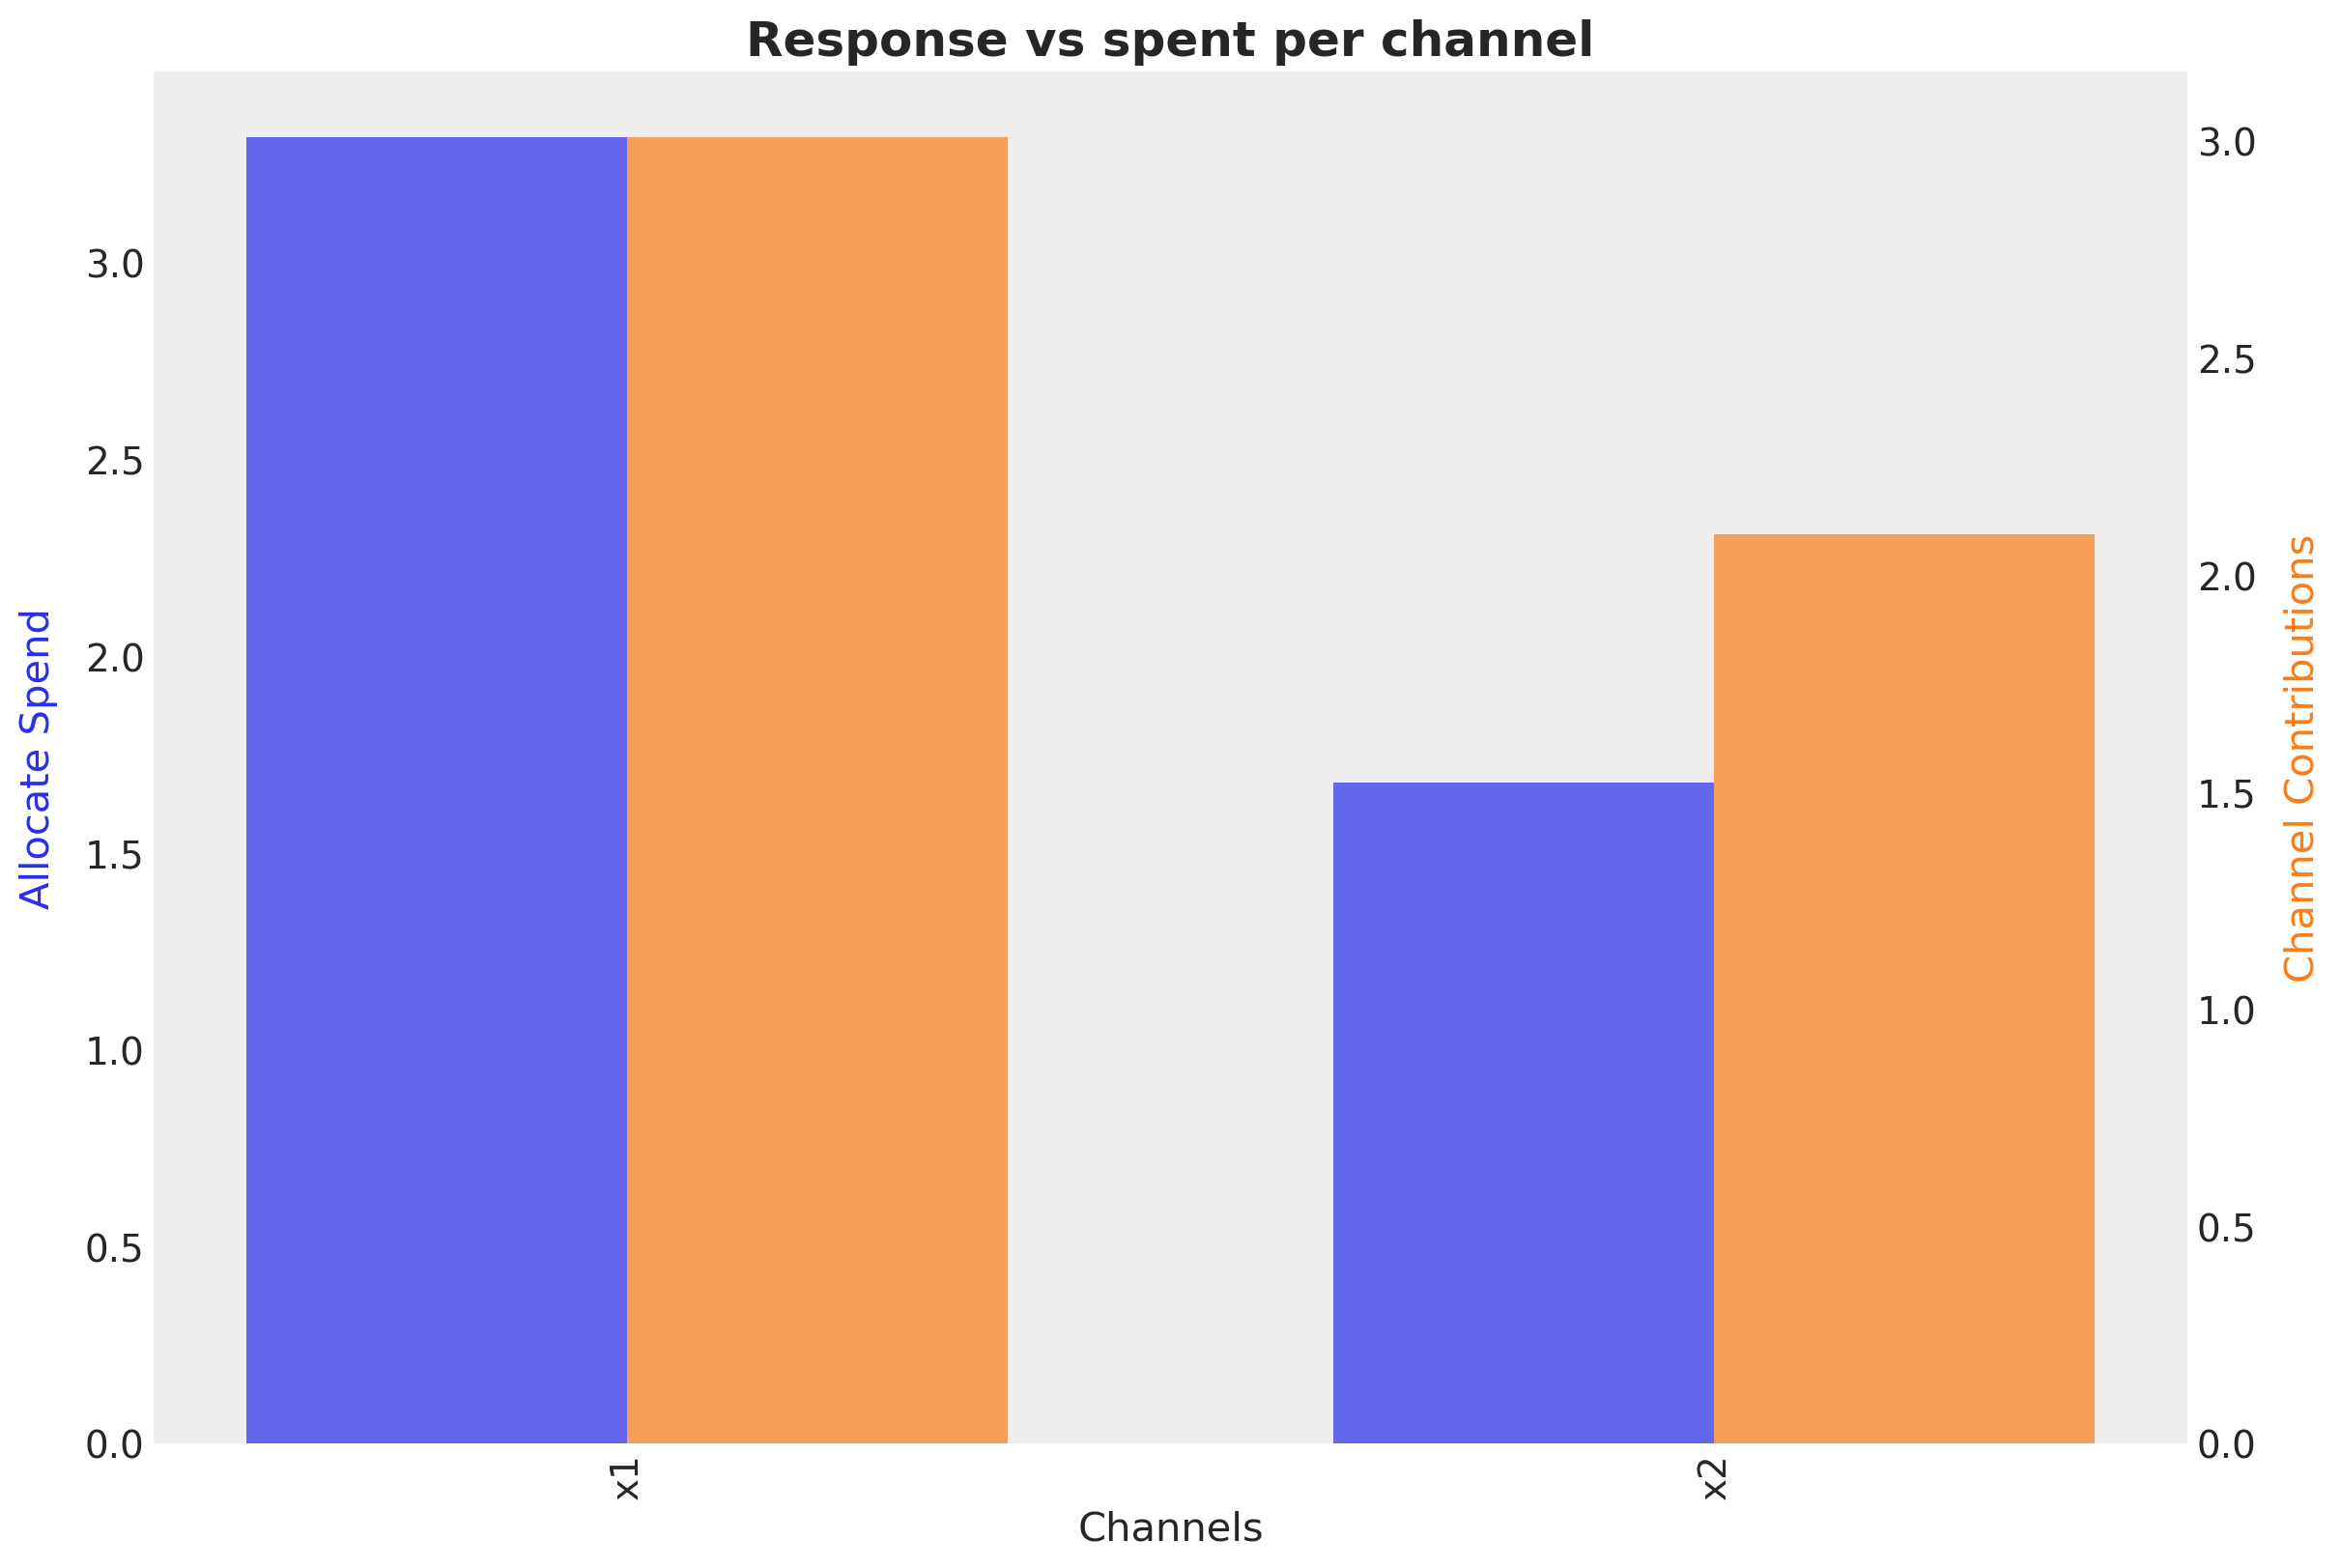

In [7]:
response_considering_risk = mmm.allocate_budget_to_maximize_response(
    budget=time_unit_budget,
    num_periods=num_periods,
    time_granularity="weekly",
    objective_function=RiskAssessment.mean_tightness_score,
    objective_function_kwargs={"alpha": 0.9},
)

print(f"Budget allocation: {mmm.optimal_allocation_dict}")
print(f"Total Allocated Budget: {np.sum(list(mmm.optimal_allocation_dict.values()))}M")

fig, ax = mmm.plot_budget_allocation(samples=response_considering_risk, figsize=(12, 8))
ax.set_title("Response vs spent per channel", fontsize=18, fontweight="bold");

Majority of the budget is allocated to $X1$. This allocation is the one that minimizes the potential risk. Basically, we are saying that we are ok with less returns, if those returns are more certain. We can observe this in the response distribution plot, which should be a tight distribution with small tails.


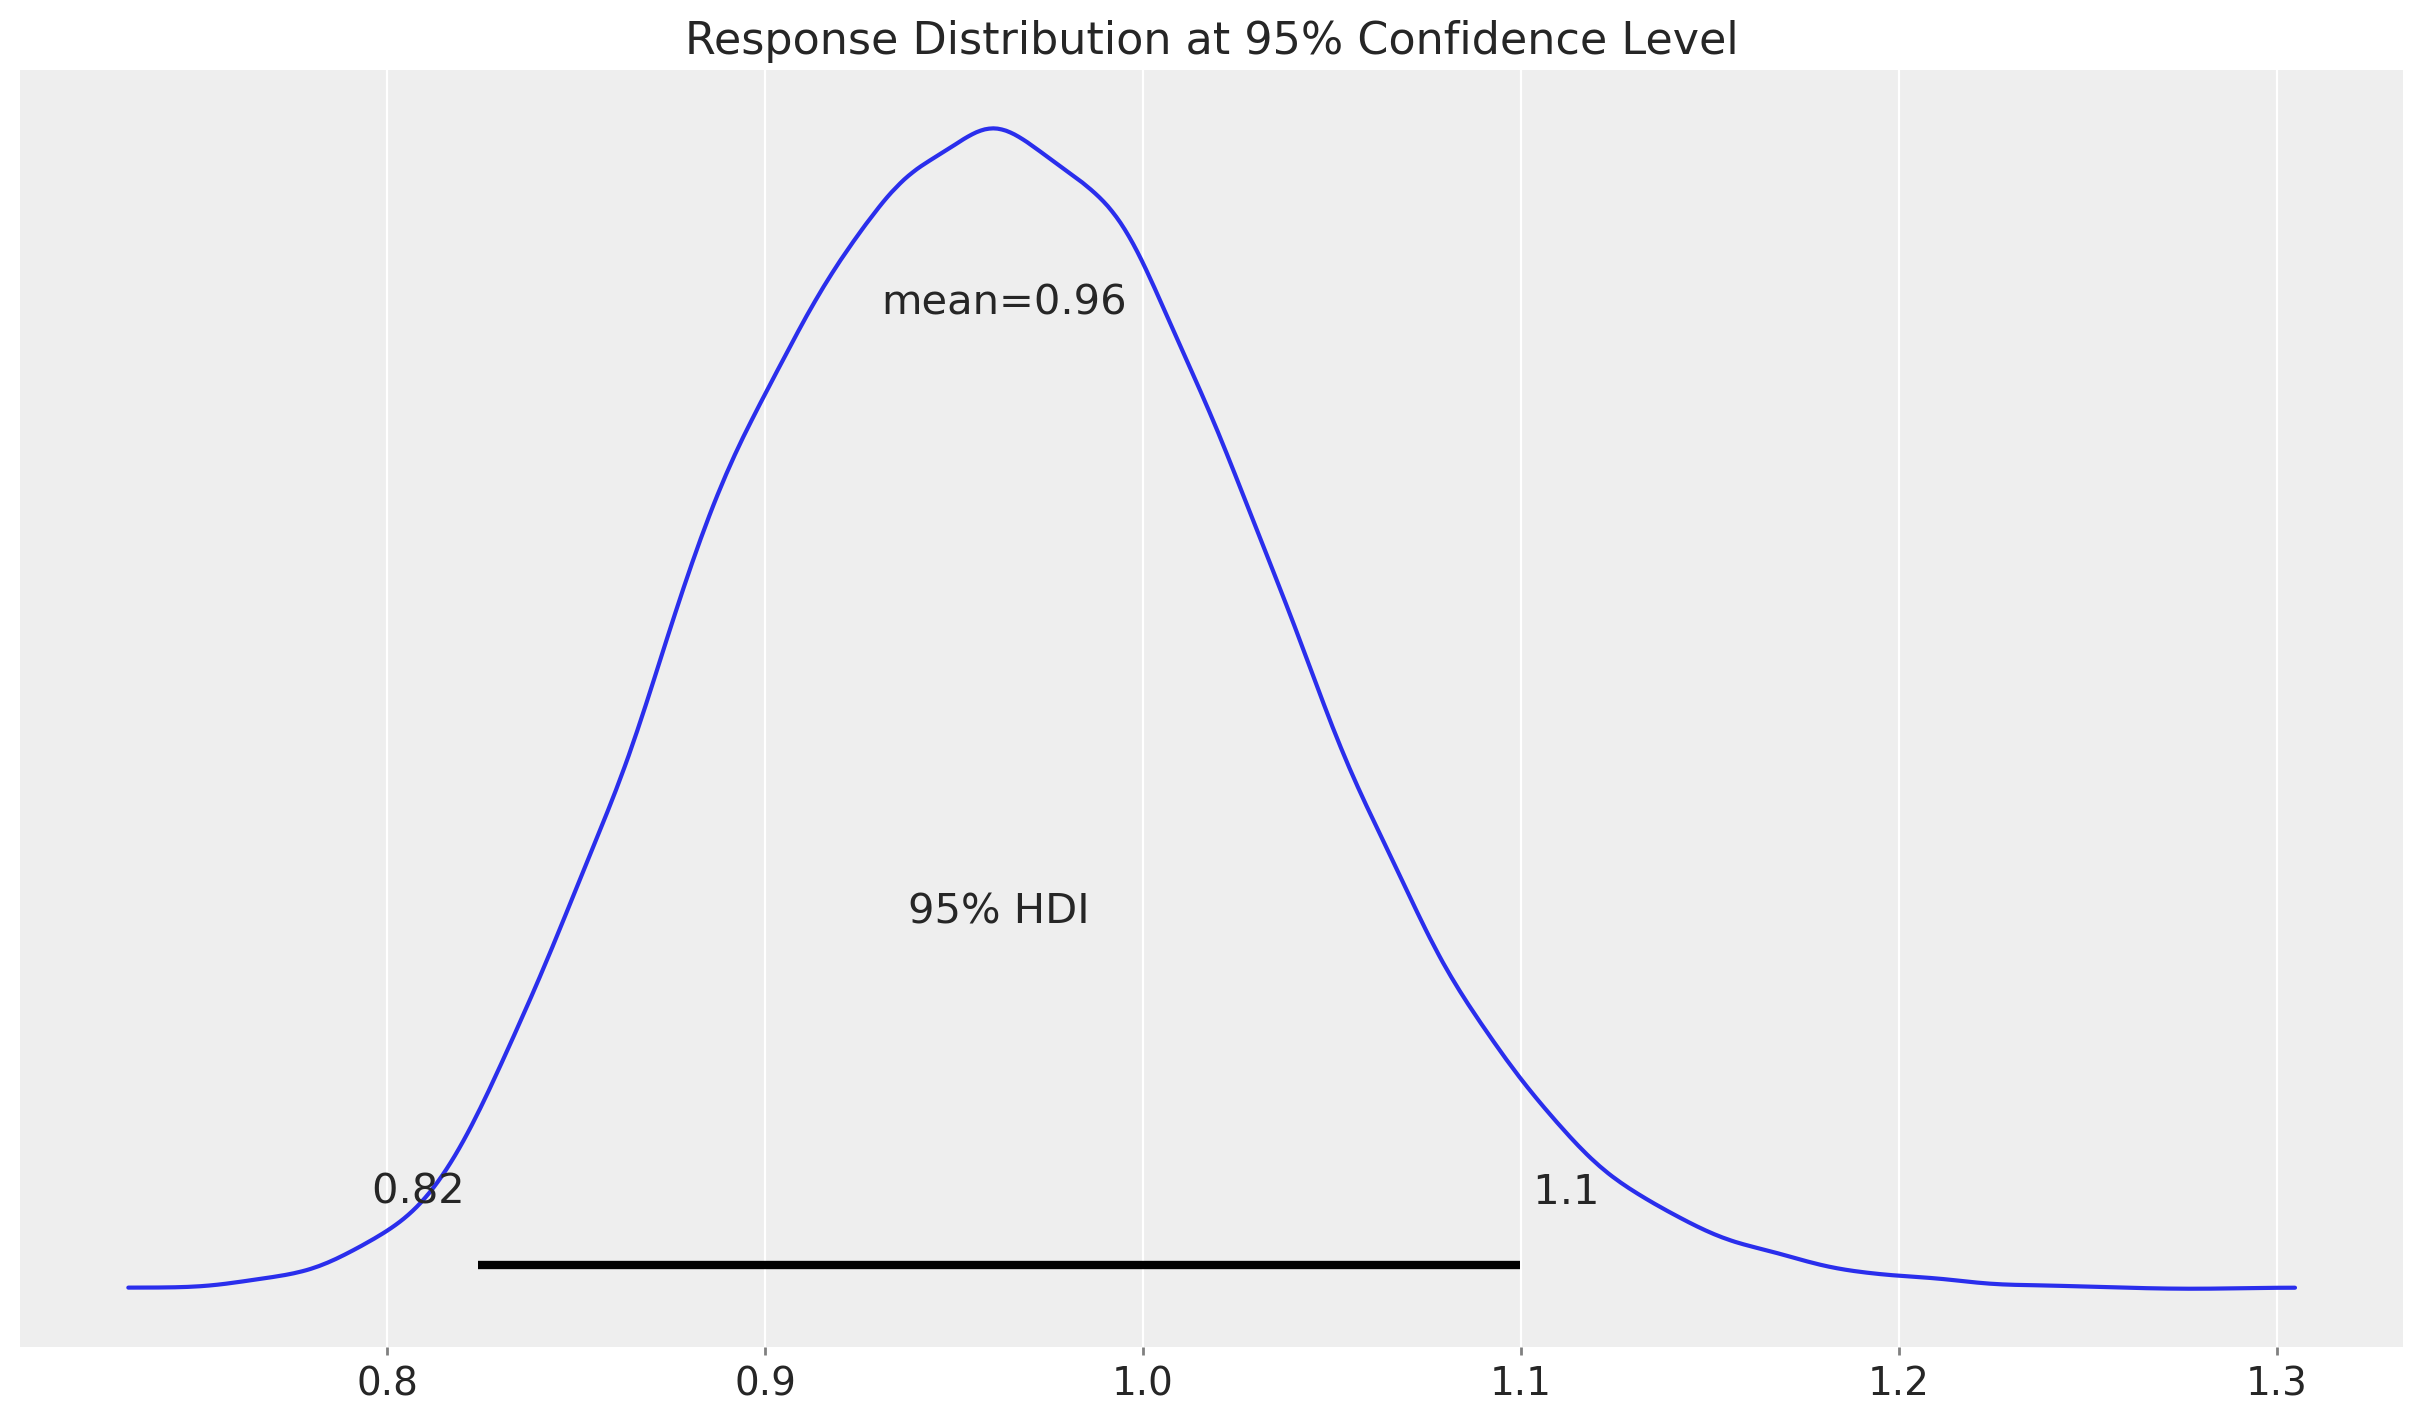

In [8]:
# Plot the response distribution by Arviz
az.plot_posterior(response_considering_risk.y.values.flatten(), hdi_prob=0.95)
plt.title("Response Distribution at 95% Confidence Level");

This makes a lot of sense, $X1$ has a response with less uncertainty, and $X2$ has a response with more uncertainty. Thats why the optimizer is allocating more budget to $X1$, becuase it represents a safer bet.

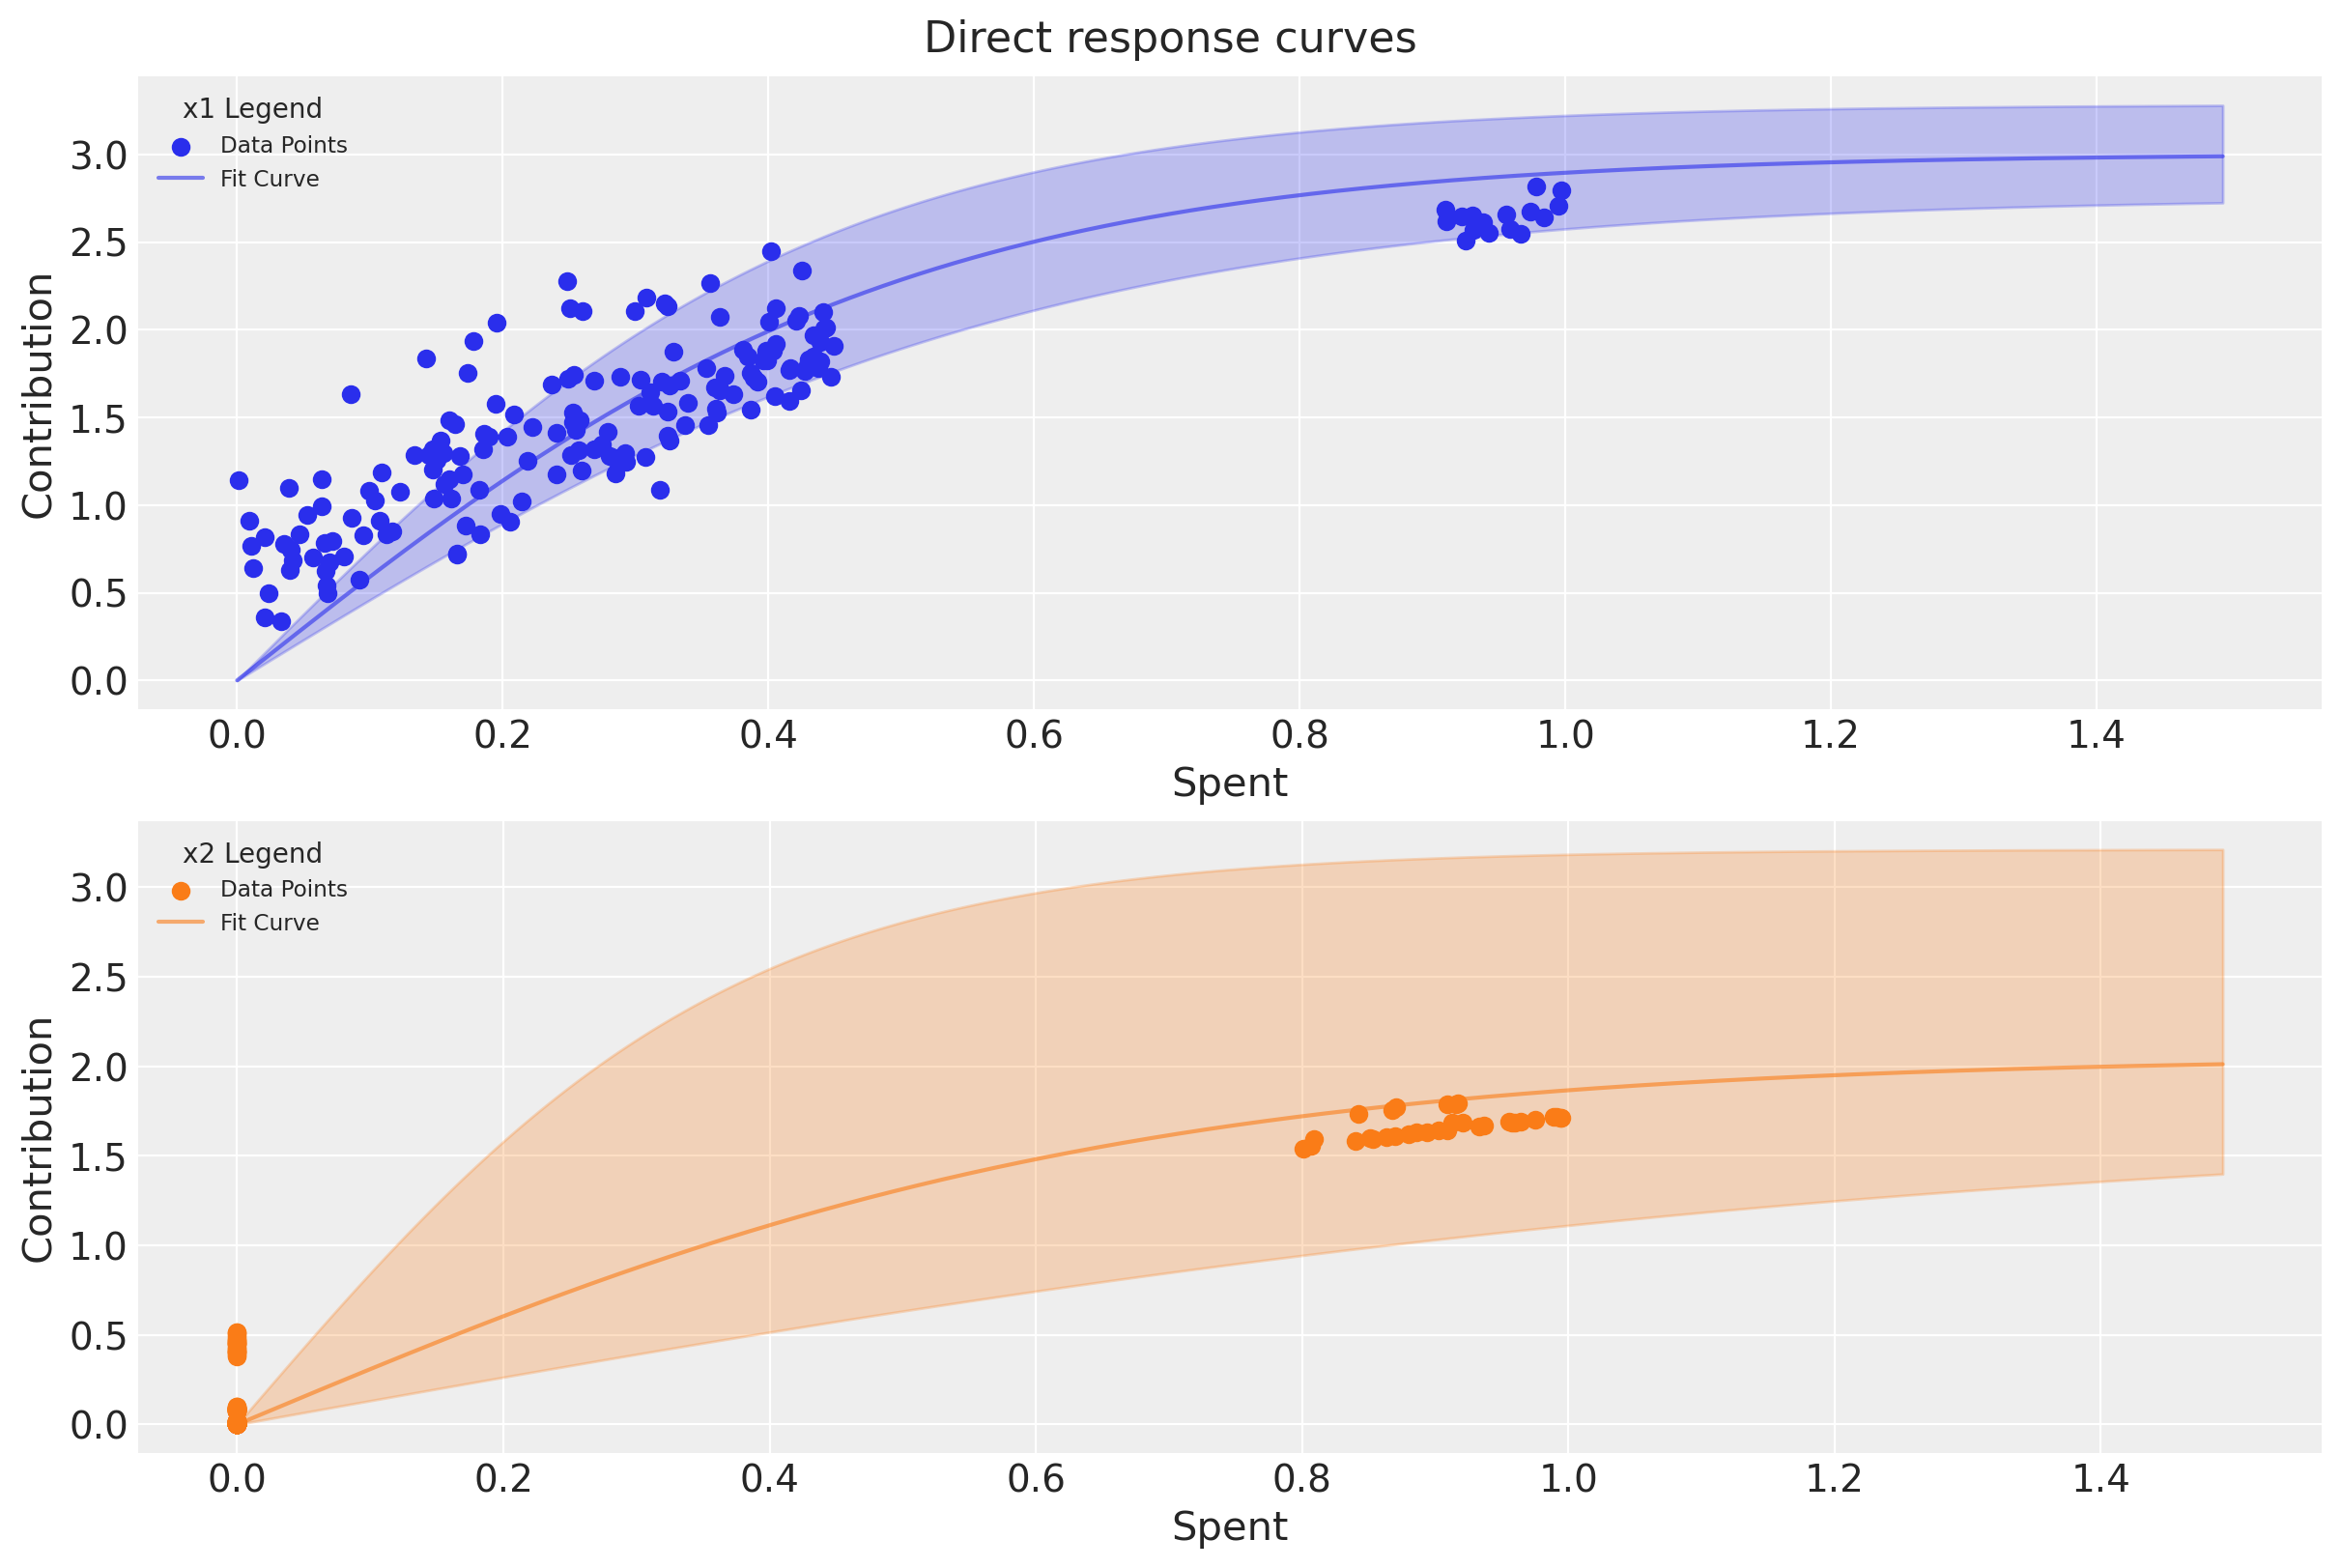

In [9]:
mmm.plot_direct_contribution_curves(show_fit=True, xlim_max=1.5);

We can exhibit this behavior on a more evident way; if we want to maximize a response that is less certain, we should get the opposite scenario. Let's set the mean tightness score with a lower alpha parameter, meaning, we have a higher risk tolerance.

Sampling: [y]


Output()

Budget allocation: {'x1': 2.88970865718624, 'x2': 2.11029134281376}
Total Allocated Budget: 5.0M


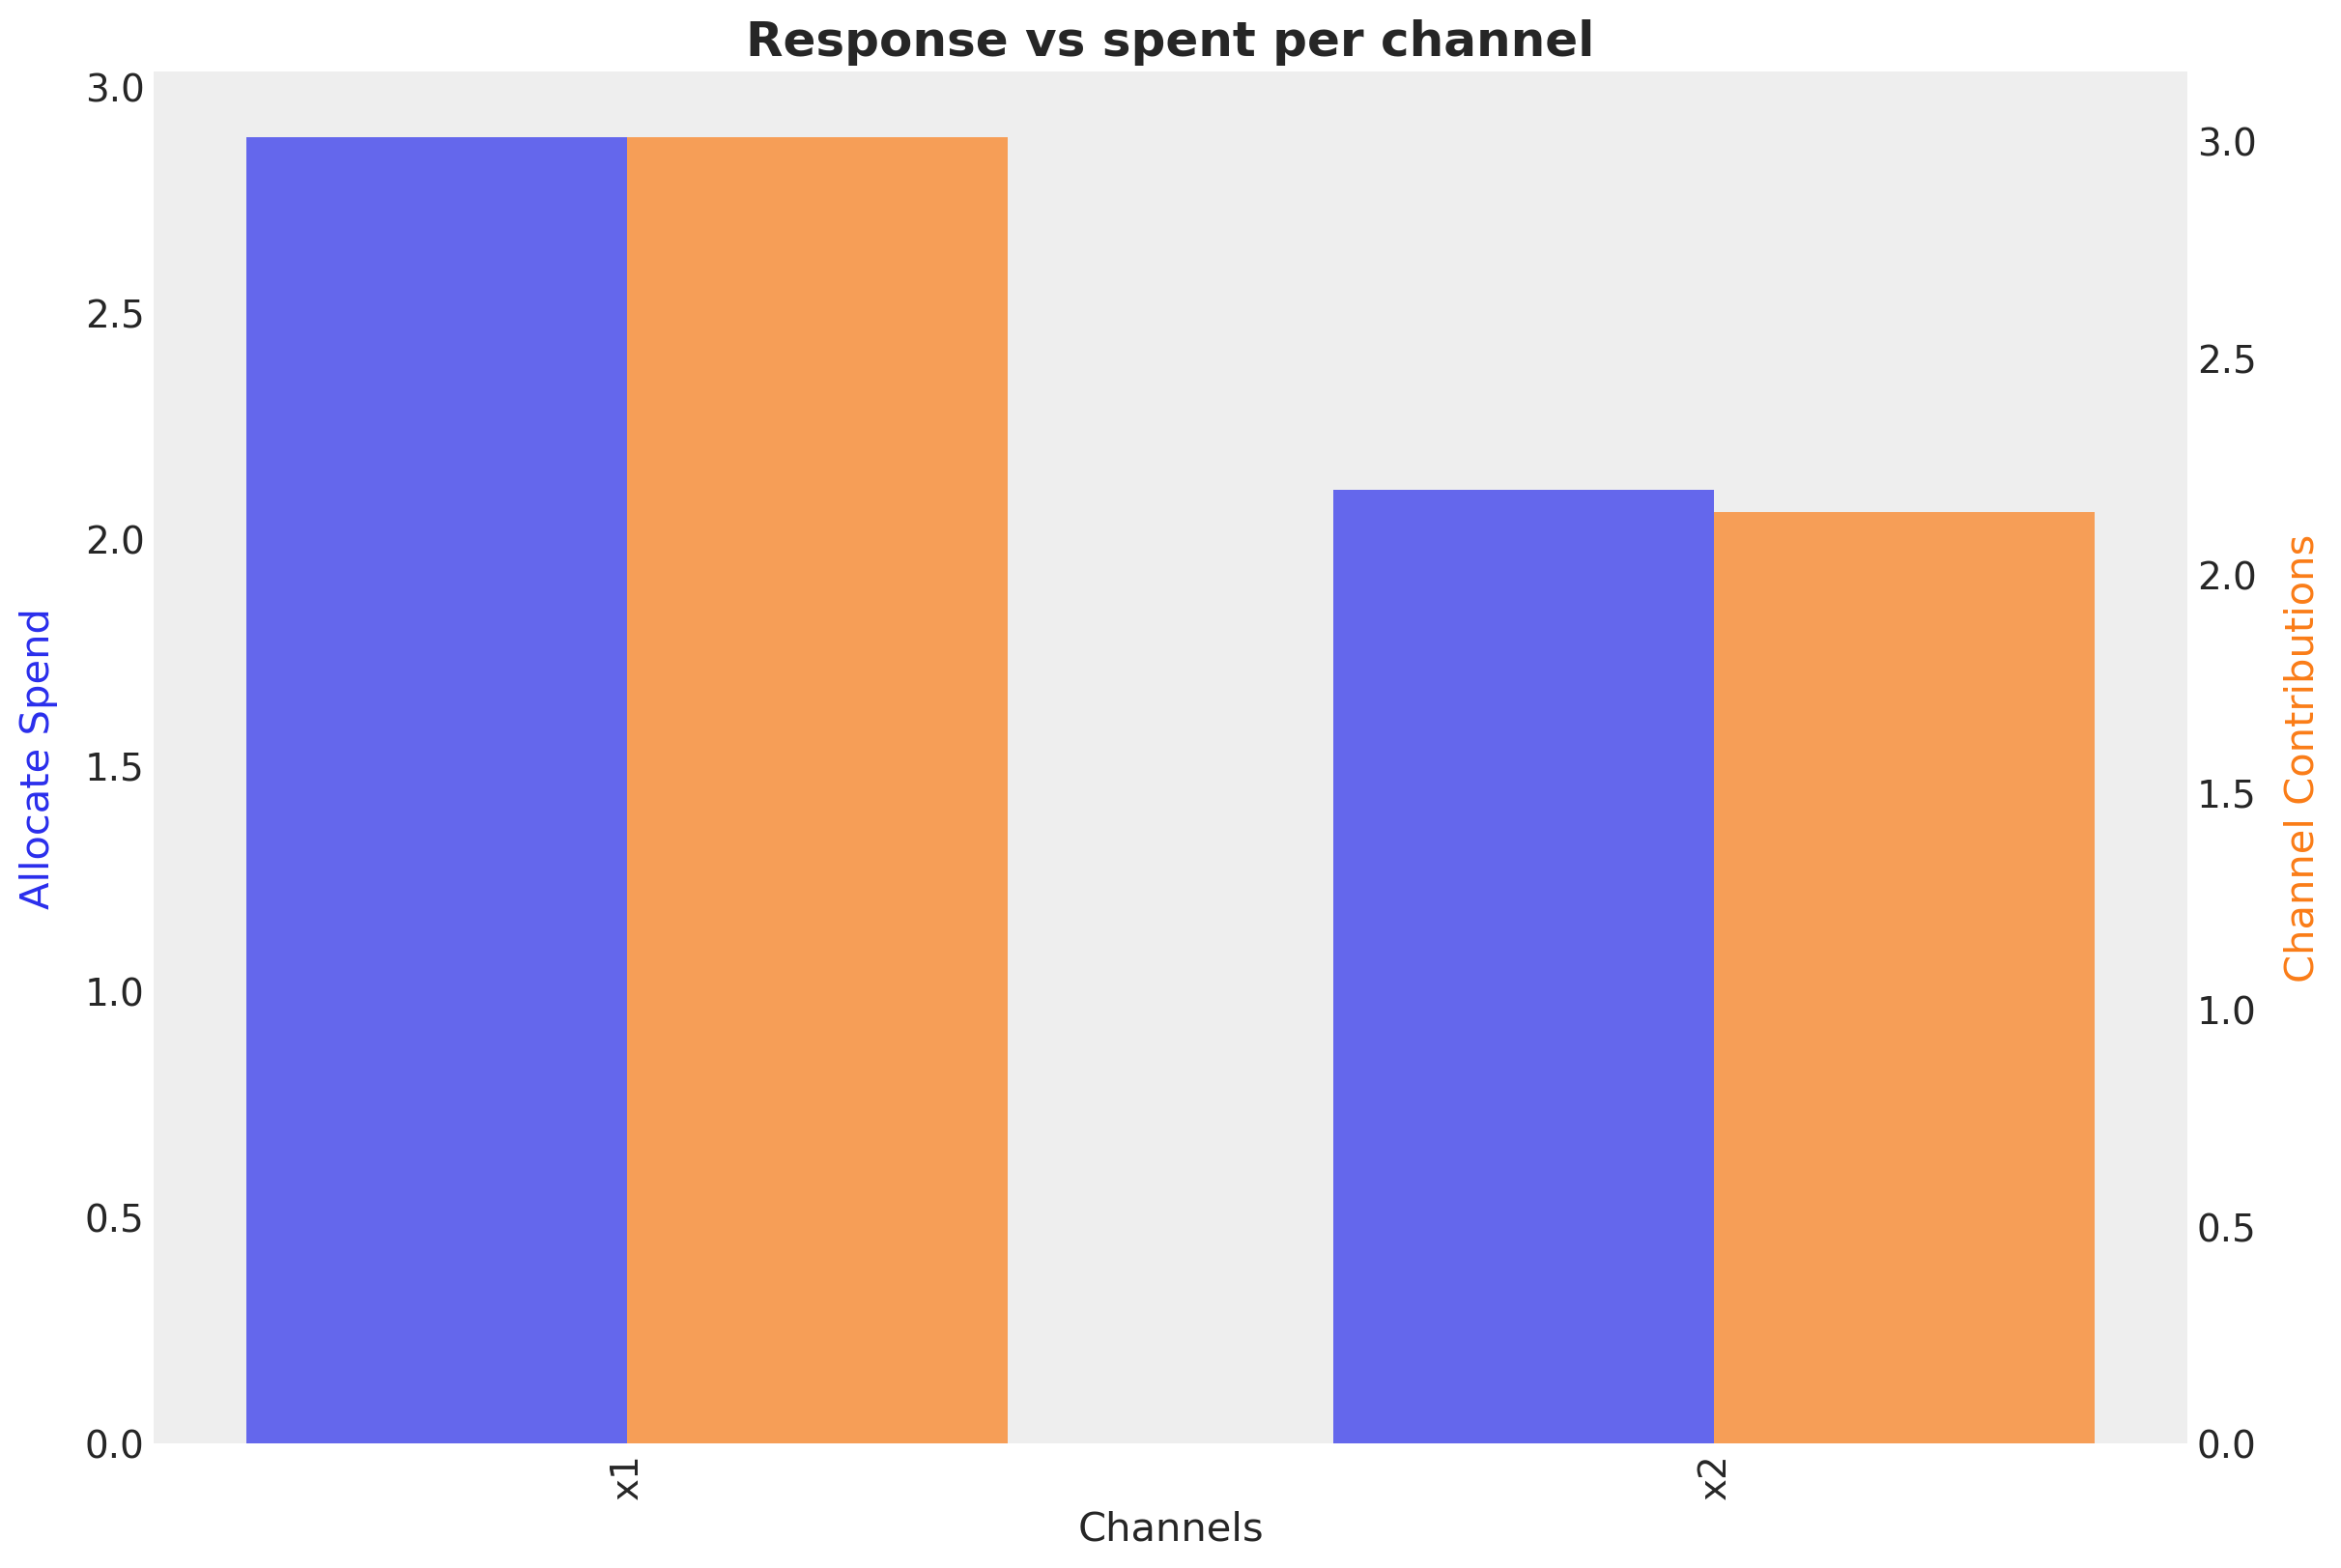

In [10]:
response_considering_risk = mmm.allocate_budget_to_maximize_response(
    budget=time_unit_budget,
    num_periods=num_periods,
    time_granularity="weekly",
    objective_function=RiskAssessment.mean_tightness_score,
    objective_function_kwargs={"alpha": 0.1},
)

print(f"Budget allocation: {mmm.optimal_allocation_dict}")
print(f"Total Allocated Budget: {np.sum(list(mmm.optimal_allocation_dict.values()))}M")

fig, ax = mmm.plot_budget_allocation(samples=response_considering_risk, figsize=(12, 8))
ax.set_title("Response vs spent per channel", fontsize=18, fontweight="bold");

We are spending more in $X2$, and less in $X1$ compared to the previous allocation. Let's see the response distribution plot, again to compare it with the previous one.

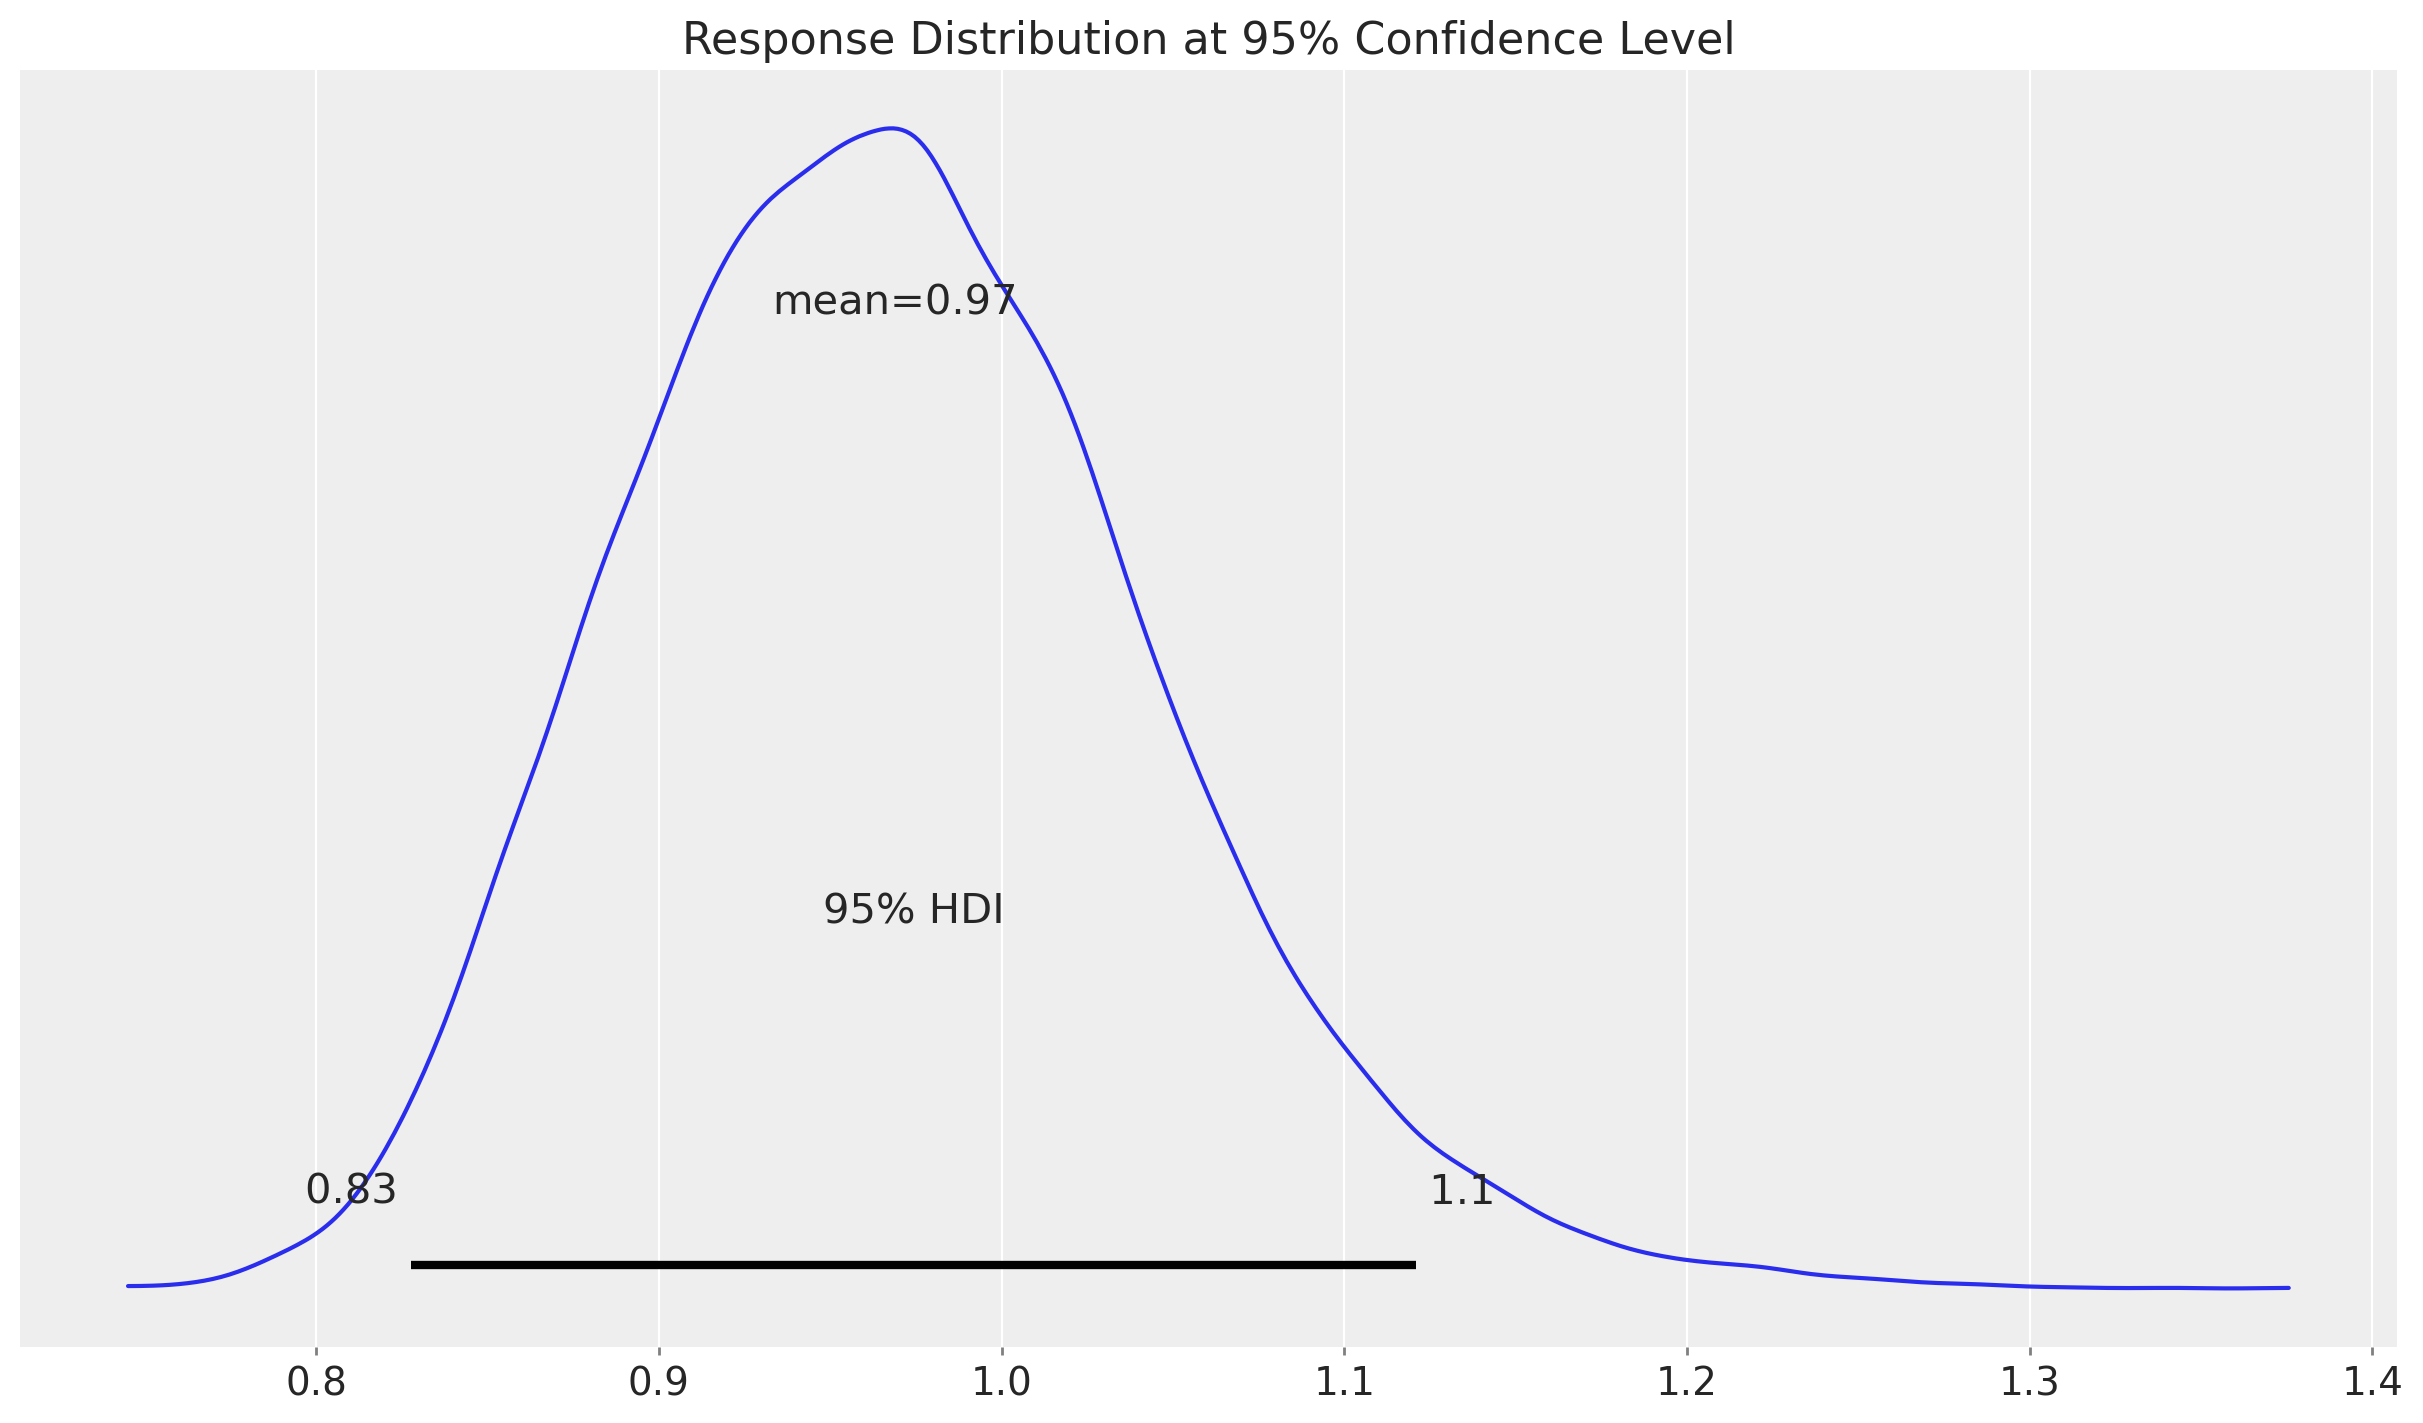

In [11]:
# Plot the response distribution by Arviz
az.plot_posterior(response_considering_risk.y.values.flatten(), hdi_prob=0.95)
plt.title("Response Distribution at 95% Confidence Level");

As expected, the distribution has bigger tails now, and the mean is higher as well. We got bigger returns, but with more risk. The extra risk is coming from the additional budget allocated to $X2$.

## Optimizing Budget Allocation using ROAS at Risk (VaR)
We can mix different risk assessment criteria to generate a more complex objective function. In this case, we will use the ROAS from each allocation, and we'll use the value at risk as our risk assessment criterion. This will help us to find the allocation that maximizes the ROAS, while minimizing the potential risk.

Value at Risk is a statistical technique used to measure the risk of loss on a portfolio or investment. In our marketing context, it helps us understand the worst expected loss (ROAS) over a specific budget allocation at a given confidence level. If we minimize the VaR, we are choosing the allocation that even in the worst case, ROAS will be higher as possible.


Sampling: [y]


Output()

Budget allocation: {'x1': 3.348665782101314, 'x2': 1.6513342178986865}
Total Allocated Budget: 5.0M


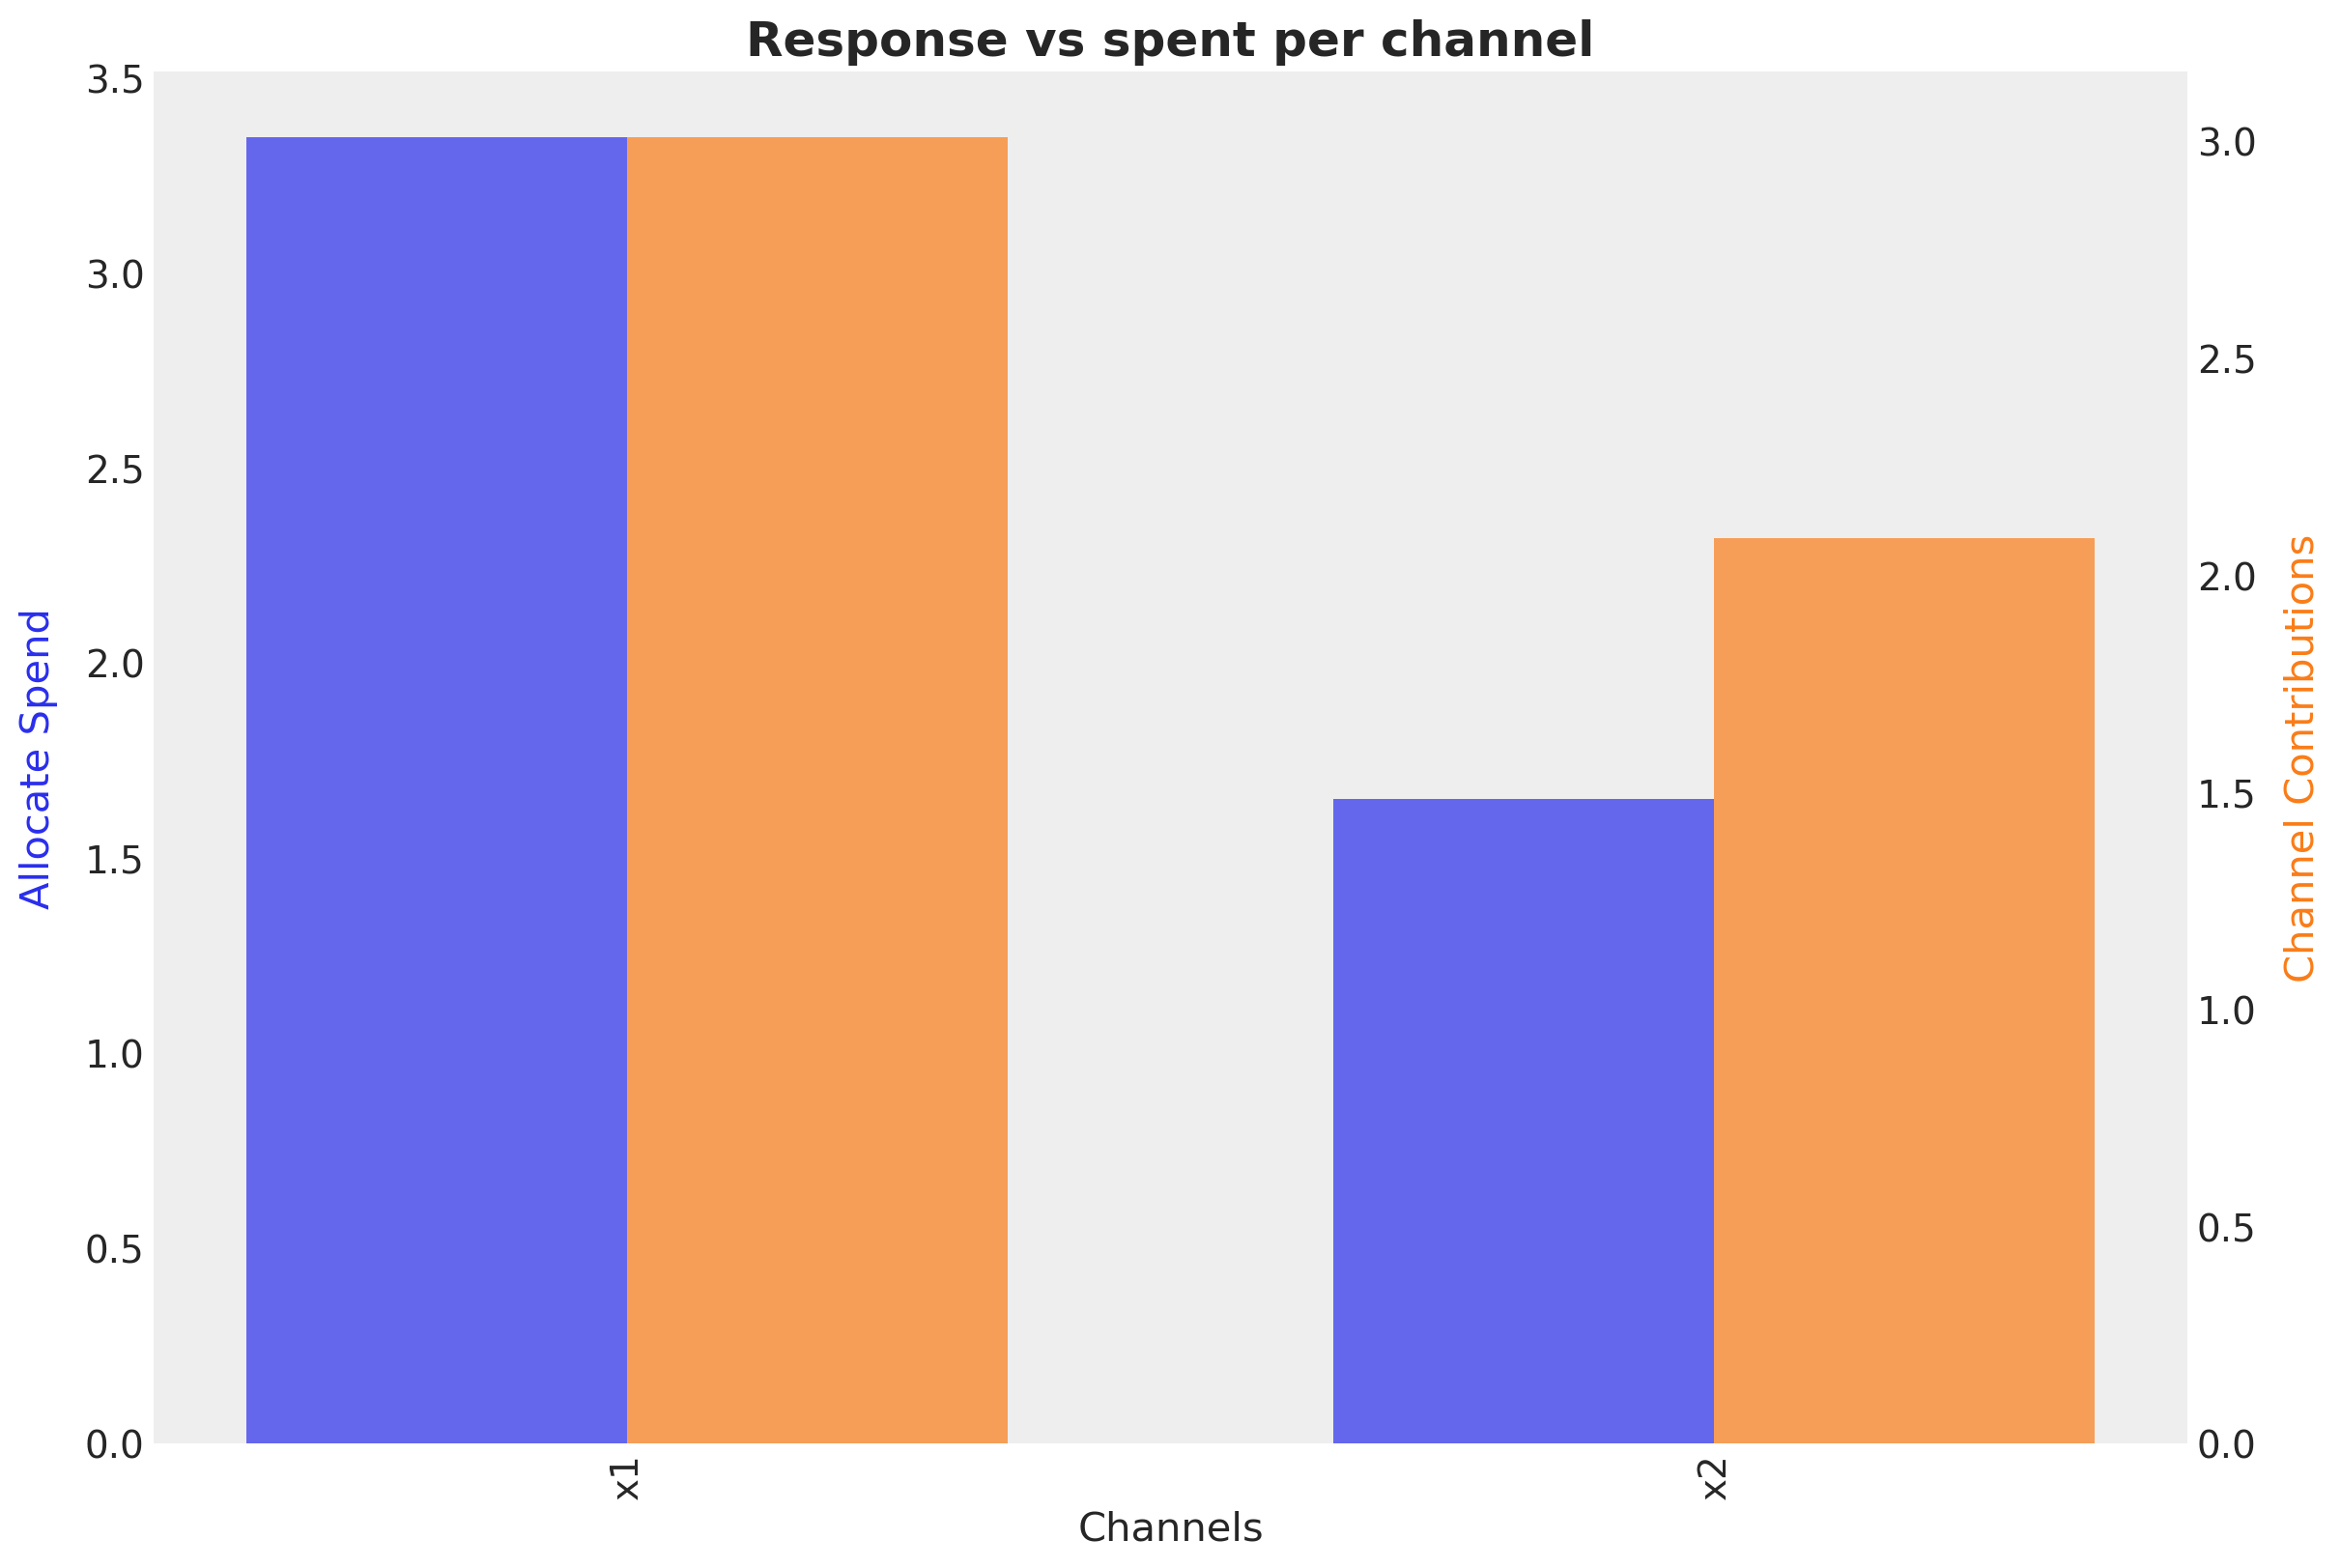

In [12]:
response_considering_risk = mmm.allocate_budget_to_maximize_response(
    budget=time_unit_budget,
    num_periods=num_periods,
    time_granularity="weekly",
    objective_function=lambda samples, assets: RiskAssessment.value_at_risk(
        samples=RiskAssessment.calculate_roas_distribution_for_allocation(
            samples, assets
        ),
        confidence_level=0.9,
    ),
)

print(f"Budget allocation: {mmm.optimal_allocation_dict}")
print(f"Total Allocated Budget: {np.sum(list(mmm.optimal_allocation_dict.values()))}M")

fig, ax = mmm.plot_budget_allocation(samples=response_considering_risk, figsize=(12, 8))
ax.set_title("Response vs spent per channel", fontsize=18, fontweight="bold");

We can see that the optimizer is allocating the budget to $X1$ again, but this time because the current combination will be the one were ROAS is higher, as possible and the risk is lower.

## Custom Risk Assessment Criterion
We can create our own risk assessment criterion by defining a function that takes the samples and the assets as inputs, and returns a scalar value that we want to optimize. In this case, we want to maximize the value at risk, considering the diversification ratio. 

We want to prefer the allocation that has the lowest value at risk, but with a high diversification between the marketing channels. Because we already understand how value at risk works, let's focus on the portafolio entropy.


In [13]:
(
    RiskAssessment.portfolio_entropy(np.array([0.1, 9.9])),
    RiskAssessment.portfolio_entropy(np.array([5, 5])),
)

(0.056001534354847345, 0.6931471805599453)

We can see that the portfolio entropy is higher when the budget is allocated evenly, meaning that the diversification is higher.

Now, we can create our own risk assessment criterion by combining the value at risk and the portfolio entropy. In this case, we'll compute the mean tightness score and will multiply the response by the entropy in the portafolio. This will moderate our score, and we'll prefer the allocation that has the highest score, but with a high diversification between the marketing channels.

In [14]:
def mts_with_diversification(samples, assets, alpha, confidence_level=0.75):
    return RiskAssessment.mean_tightness_score(samples, alpha, confidence_level) * (
        1 + RiskAssessment.portfolio_entropy(assets)
    )

Sampling: [y]


Output()

Budget allocation: {'x1': 2.6638410883640313, 'x2': 2.3361589116359687}
Total Allocated Budget: 5.0M


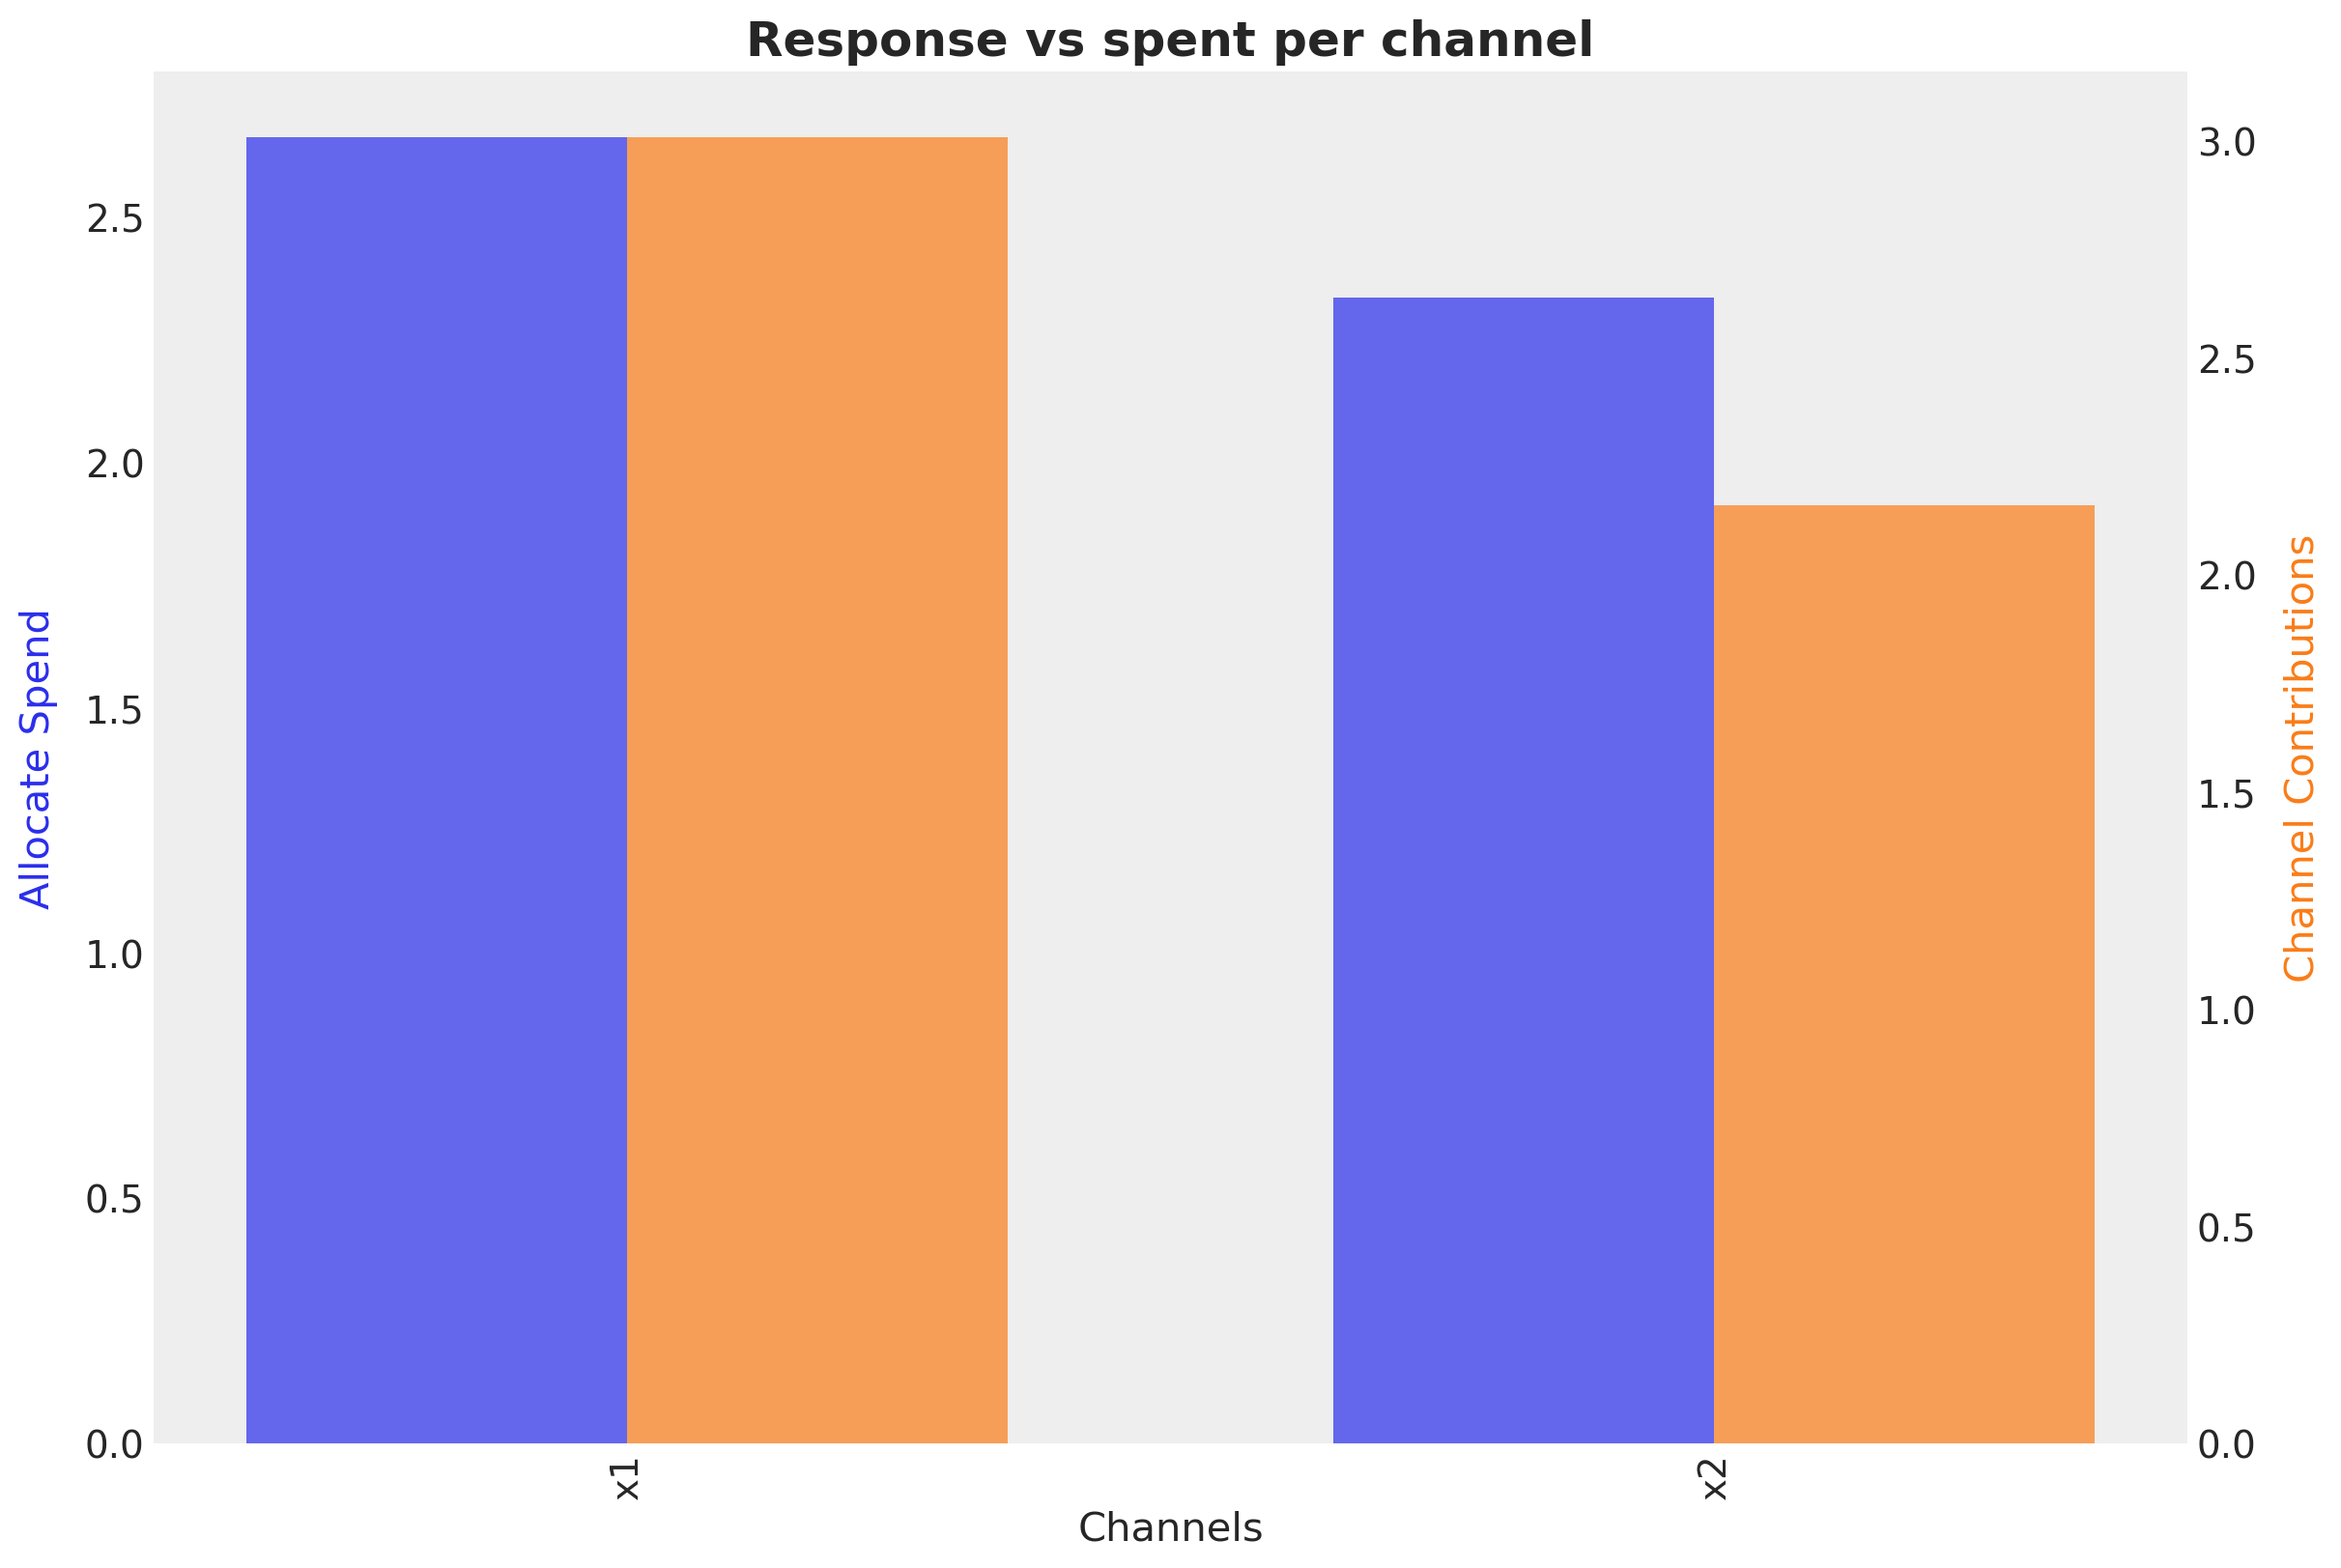

In [15]:
response_considering_risk = mmm.allocate_budget_to_maximize_response(
    budget=time_unit_budget,
    num_periods=num_periods,
    time_granularity="weekly",
    objective_function=lambda samples, assets: mts_with_diversification(
        samples, assets, 0.9
    ),
)

print(f"Budget allocation: {mmm.optimal_allocation_dict}")
print(f"Total Allocated Budget: {np.sum(list(mmm.optimal_allocation_dict.values()))}M")

fig, ax = mmm.plot_budget_allocation(samples=response_considering_risk, figsize=(12, 8))
ax.set_title("Response vs spent per channel", fontsize=18, fontweight="bold");

We can see that the optimizer is allocating the budget more evenly between the two channels. $X1$ has an allocation of 2.66M, and $X2$ has an allocation of 2.33M. This allocation is more balanced than the previous ones. Nevertheless, the total allocated budget is more balanced, the risk is higher, in response terms.

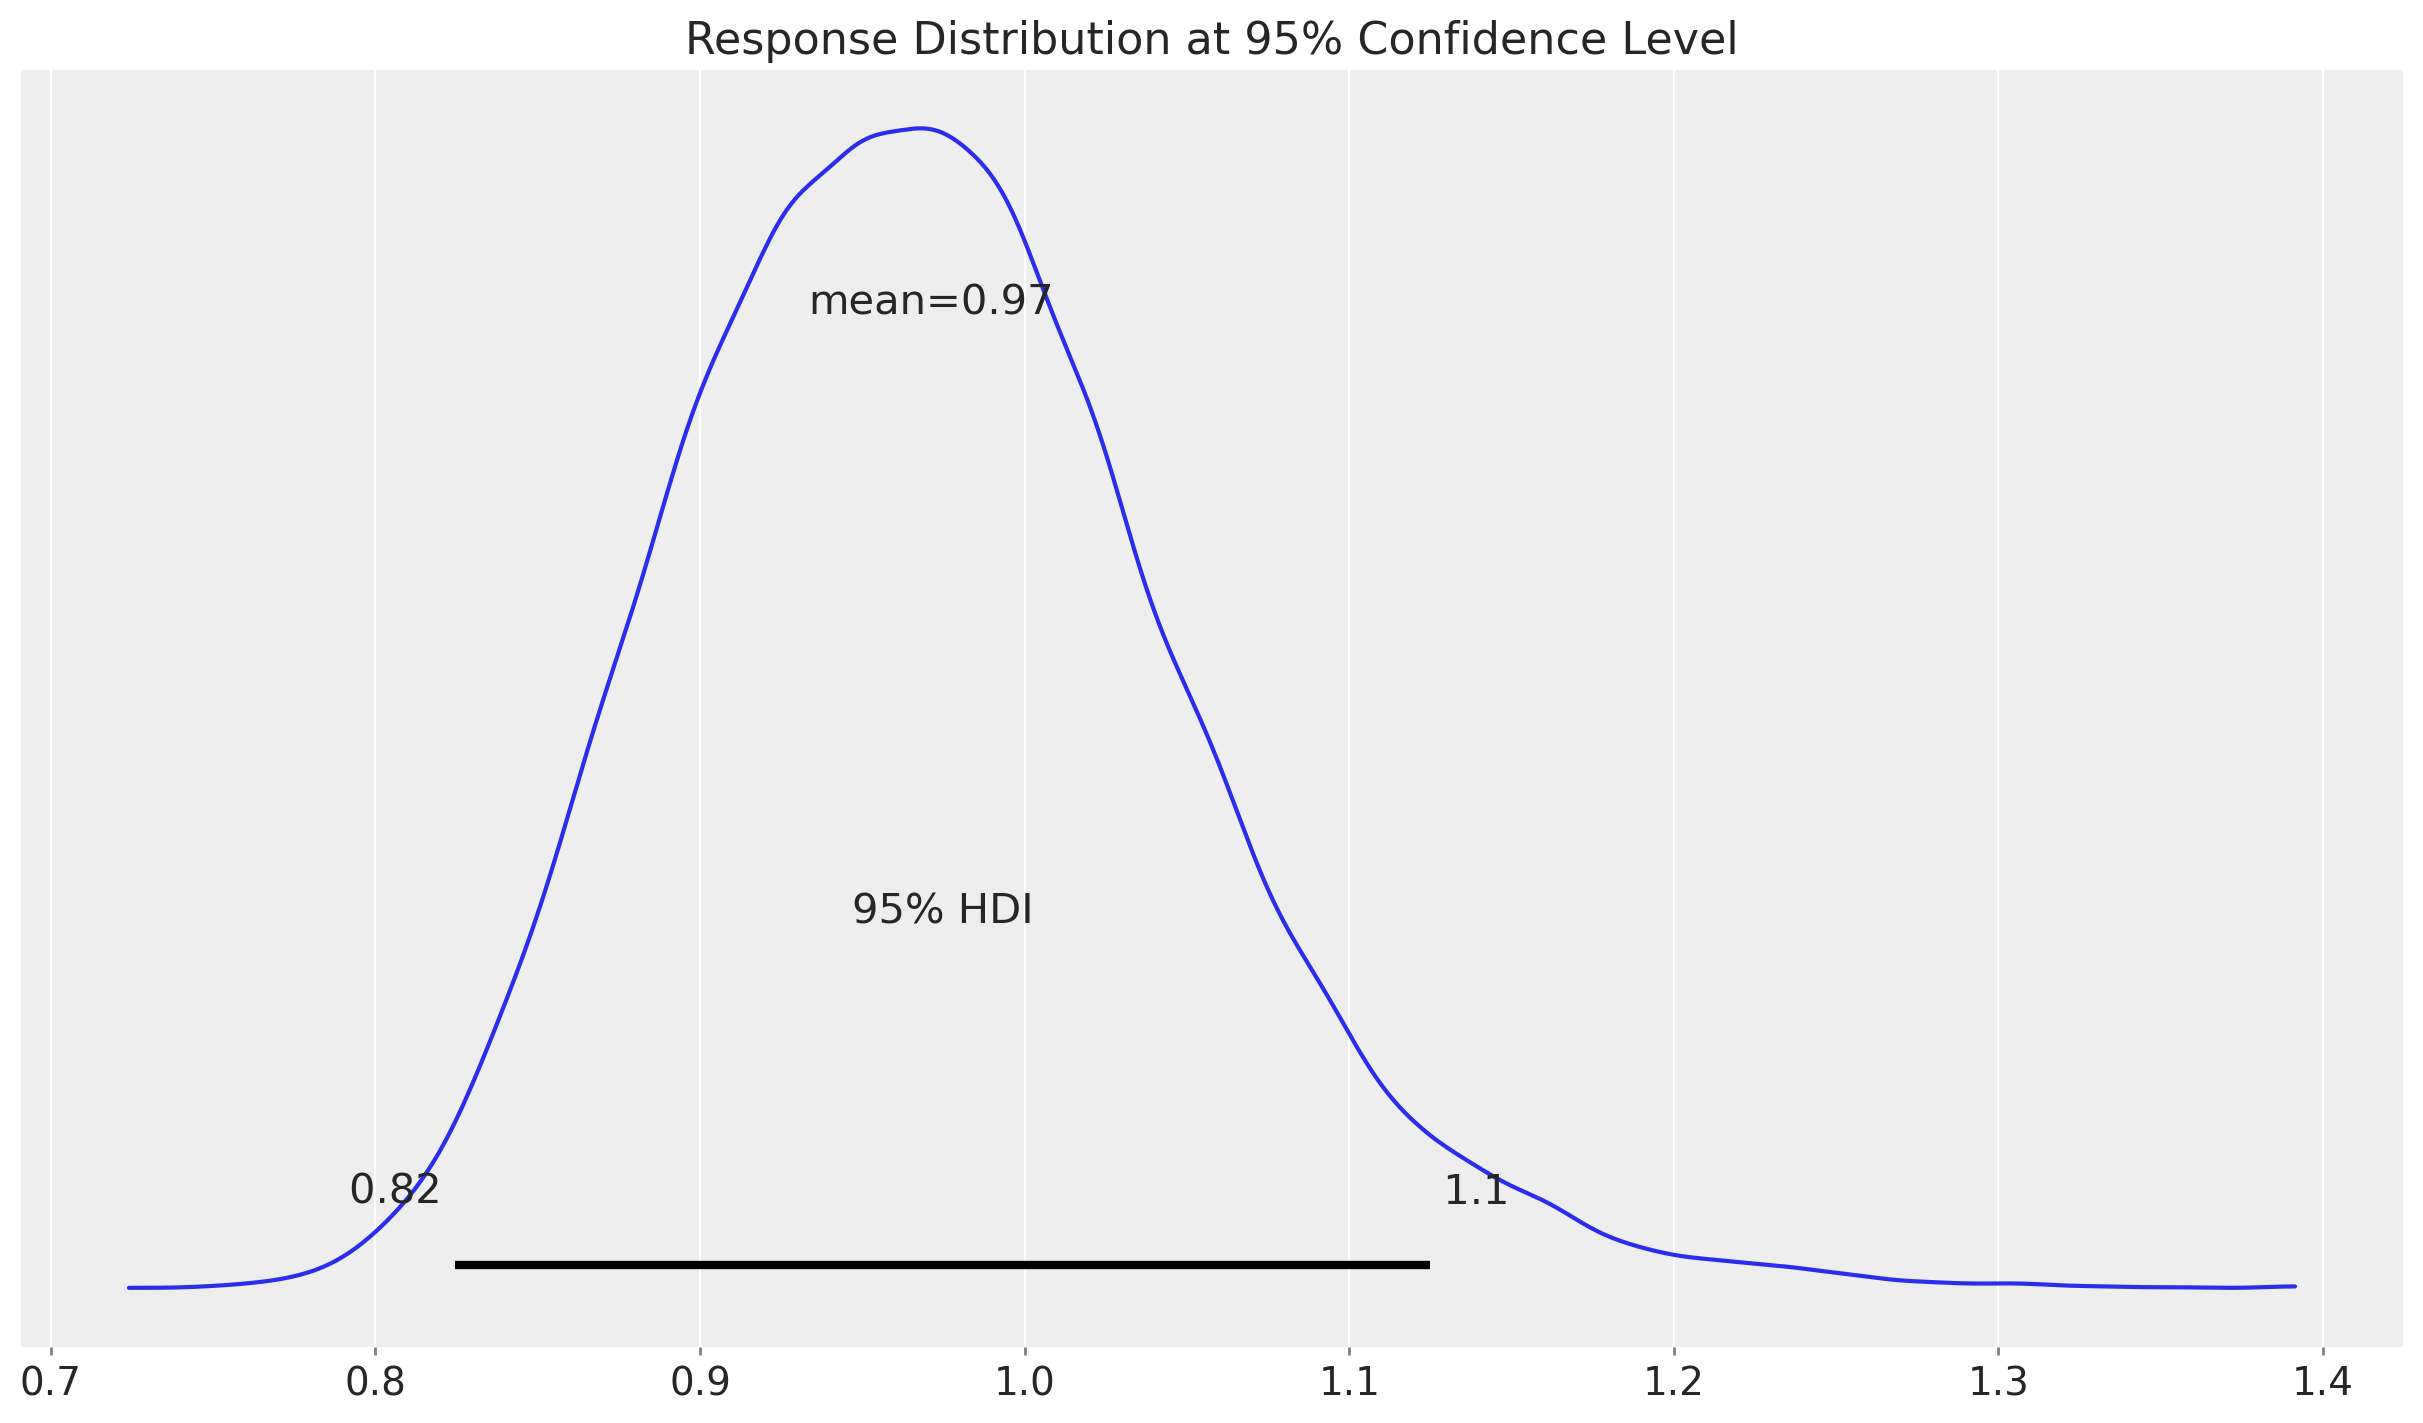

In [16]:
# Plot the response distribution by Arviz
az.plot_posterior(response_considering_risk.y.values.flatten(), hdi_prob=0.95)
plt.title("Response Distribution at 95% Confidence Level");

## Conclusion
In this notebook, we have seen how to assess the risk associated with different budget allocations, based on different strategies, and how to generate a budget allocation that is optimal under a risk tolerance criterion. We have used three different risk assessment criteria: Mean Tightness Score (MTS), Value at Risk (VaR), and a custom criterion that takes into account both the mean tightness score and the diversification ratio.

Now it's your turn to create your own risk assessment criterion, and use it to optimize your budget allocation.

In [17]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pytensor

Last updated: Sat Nov 02 2024

Python implementation: CPython
Python version       : 3.10.15
IPython version      : 8.29.0

pytensor: None

arviz         : 0.20.0
pymc_marketing: 0.10.0
matplotlib    : 3.9.2
numpy         : 1.26.4

Watermark: 2.5.0

